### Цели проекта

Задача работы — помочь удержать уровень покупательской активности существующих клиентов с помощью персонализированных предложений, направленных на пользователей с высокой вероятностью её снижения 

В качестве исходных данных нам предоставлено четыре таблицы с данными с продуктовым и финансовым поведением, поведением на сайте, маркетинговыми коммуникациям и целевой признак — покупательская активность(«снизилась», если клиент стал покупать меньше товаров, и «прежний уровень»). 

Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента и промаркировать уровень покупательской активности клиентов.

После определения модели нужно обогатить сводную таблицу дополнительными данными финансового департамента о прибыльности клиента. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегмент покупателей и разработать для них персонализированные предложения.

### Импорт библиотек

In [728]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [729]:
pip install --upgrade scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [730]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [731]:
pip install alibi[shap] -q

zsh:1: no matches found: alibi[shap]
Note: you may need to restart the kernel to use updated packages.


In [732]:
# pip install phik -q
# pip install --upgrade scikit-learn -q
# pip install shap -q
# pip install alibi[shap]

In [733]:
import math
import phik
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import (
    OneHotEncoder, StandardScaler,MinMaxScaler, RobustScaler,
    LabelEncoder,PolynomialFeatures,OrdinalEncoder
)
from sklearn.metrics import (
    confusion_matrix, mean_absolute_error,
    recall_score, precision_score, accuracy_score,
    r2_score, recall_score,precision_score, f1_score,
    roc_auc_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings

## Загрузка данных

### Загрузка таблиц

Загрузим таблицы из четырех предоставленных файлов и проверим их содержание при помощи sample и info

In [737]:
df_market = pd.read_csv('/Users/germanchernukhin/Downloads/market_file (1).csv')
df_market.sample(5)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
604,215952,Прежний уровень,стандарт,да,4.9,4,869,0.24,Мелкая бытовая техника и электроника,3,1,4,8
779,216127,Прежний уровень,стандарт,да,4.5,4,603,0.15,Мелкая бытовая техника и электроника,3,4,5,13
865,216213,Прежний уровень,стандарт,да,3.3,4,410,0.13,Домашний текстиль,6,2,8,11
928,216276,Прежний уровень,премиум,да,6.3,5,925,0.13,Техника для красоты и здоровья,5,3,3,11
728,216076,Прежний уровень,стандарт,да,5.1,3,460,0.28,Техника для красоты и здоровья,3,0,4,14


In [738]:
df_market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [739]:
df_m_money = pd.read_csv('/Users/germanchernukhin/Downloads/market_money.csv')
df_m_money.sample(5)

,id,Период,Выручка
2475,216173,предыдущий_месяц,4554.0
1520,215854,текущий_месяц,4966.2
2635,216226,препредыдущий_месяц,4409.0
44,215362,препредыдущий_месяц,4765.0
1354,215799,препредыдущий_месяц,4648.0


In [740]:
df_m_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [741]:
df_time = pd.read_csv('/Users/germanchernukhin/Downloads/market_time.csv')
df_time.sample(5)

,id,Период,минут
1663,216179,предыдцщий_месяц,18
1273,215984,предыдцщий_месяц,15
1046,215871,предыдцщий_месяц,14
696,215696,предыдцщий_месяц,16
2187,216441,предыдцщий_месяц,20


In [742]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Таблица с прибылью использует сепаратор ";" и отделяет десятичные значения через ","

In [744]:
df_money = pd.read_csv('/Users/germanchernukhin/Downloads/money.csv', sep=';', decimal=',')
df_money.sample(5)

,id,Прибыль
809,216157,3.95
130,215478,4.97
1153,216501,2.24
89,215437,4.85
1206,216554,5.66


In [745]:
df_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Проверка на соответствие описанию

В таблице df_m_money есть данные за текущий, предыдущий и за пред предыдущий месяц, которого не было в описании. Также неизвестно являются ли данные за текущий месяц данными за весь месяц или только за его часть. Количество строк в этой таблице соответствует трем записям для каждого id из первой таблицы. df_time содержит данные за текущий и предыдущий месяц.

Таблица с данными о среднемесячной прибыли выглядит необычно, значение прибыли существенно ниже выручки. Вряд ли магазин работает с маржинальностью 1%, возможно "," это не разделитель для сотых, или, что для подсчета выручки и прибыли использован разные единицы, или, что прибыль это на самом деле маржа, хотя и в этом случае, показатель неправдоподобно низок.

## Переработка данных

Приведем название колонок в df_market к единообразию

In [750]:
df_market.columns = df_market.columns.str.replace('_', ' ')
df_market.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность',
       'Акционные покупки', 'Популярная категория',
       'Средний просмотр категорий за визит',
       'Неоплаченные продукты штук квартал', 'Ошибка сервиса',
       'Страниц за визит'],
      dtype='object')

Проверим, есть ли повторы в колонках id

In [752]:
print(len(df_market['id'].unique()))
print(len(df_m_money['id'].unique()))
print(len(df_time['id'].unique()))
print(len(df_money['id'].unique()))

1300
1300
1300
1300


Повторов нет, пропусков, как мы видели из применения .info(), тоже нет. Проверим дубликаты.

In [754]:
df_market_d = df_market.drop('id', axis=1)
df_market[df_market_d.duplicated(keep=False)]

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
337,215685,Снизилась,стандарт,нет,4.4,5,517,0.23,Товары для детей,1,2,5,11
338,215686,Снизилась,стандарт,нет,4.3,4,460,0.16,Техника для красоты и здоровья,2,1,3,6
339,215687,Снизилась,стандарт,да,3.9,4,627,0.24,Товары для детей,3,3,7,8
340,215688,Снизилась,стандарт,да,5.5,4,703,0.14,Мелкая бытовая техника и электроника,2,1,3,7
341,215689,Снизилась,стандарт,нет,5.0,4,136,0.27,Товары для детей,3,4,4,17
342,215690,Снизилась,стандарт,да,4.8,4,907,0.30,Косметика и аксесуары,2,1,1,6
343,215691,Снизилась,стандарт,нет,3.9,5,600,0.17,Домашний текстиль,1,7,4,10
344,215692,Снизилась,стандарт,да,3.3,3,871,0.20,Техника для красоты и здоровья,2,4,2,17
345,215693,Снизилась,стандарт,да,5.6,5,574,0.28,Домашний текстиль,3,2,3,9
346,215694,Снизилась,премиум,да,5.5,5,982,0.94,Мелкая бытовая техника и электроника,3,1,8,10


In [755]:
len(df_market[df_market_d.duplicated()])

11

In [756]:
months_filter = df_m_money[df_m_money['Выручка']>0].pivot_table(index='id', values=['Период'], aggfunc=
                                                                {'Период':'count'}).reset_index()
months_filter = months_filter[months_filter['Период']<3]
len(months_filter)

3

In [757]:
df_dup = df_market[df_market_d.duplicated()]['id'].tolist()
df_dup.extend(months_filter['id'].tolist())
len(df_dup)

14

Мы обнаружили трех пользователей с покупательской активностью менее трех месяцев и 11 случаев совпадения всех признаков, при разных id. Проверим две совпавшие строки по id в других таблицах

In [759]:
df_m_money[df_m_money['id']==215685]

,id,Период,Выручка
1011,215685,препредыдущий_месяц,4382.0
1012,215685,предыдущий_месяц,3130.0
1013,215685,текущий_месяц,4345.5


In [760]:
df_m_money[df_m_money['id']==215895]

,id,Период,Выручка
1641,215895,предыдущий_месяц,3130.0
1642,215895,текущий_месяц,4345.5
1643,215895,препредыдущий_месяц,4382.0


Данные совпали, похоже дубликаты настоящие. Удалим эти id из таблиц и проверим число строк после удаления в датафреймах

In [762]:
df_market = df_market[~df_market['id'].isin(df_dup)]

In [763]:
len(df_market)

1286

In [764]:
df_m_money = df_m_money[~df_m_money['id'].isin(df_dup)]

In [765]:
len(df_m_money)

3858

In [766]:
df_money = df_money[~df_money['id'].isin(df_dup)]

In [767]:
len(df_money)

1286

In [768]:
df_time = df_time[~df_time['id'].isin(df_dup)]

In [769]:
len(df_time)

2572

Тип данных в столбцах указан верно. В остальном каких-то очевидных проблем нет

## Исследовательский анализ данных

### Общий обзор количественных признаков 

Большая часть данных в таблицах количественные, посмотрим на базовые статистические показатели данных через .describe()

In [774]:
df_market.describe().round(3)

,id,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит
count,1286.000,1286.000,1286.000,1286.000,1286.000,1286.000,1286.000,1286.000,1286.000
mean,215999.834,4.252,4.007,602.941,0.321,3.277,2.840,4.186,8.175
std,376.066,1.017,0.696,249.163,0.250,1.355,1.972,1.951,3.975
min,215349.000,0.900,3.000,121.000,0.110,1.000,0.000,0.000,1.000
25%,215672.250,3.700,4.000,408.500,0.170,2.000,1.000,3.000,5.000
50%,216004.500,4.200,4.000,607.500,0.240,3.000,3.000,4.000,8.000
75%,216325.750,4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000
max,216647.000,6.600,5.000,1079.000,0.990,6.000,10.000,9.000,20.000


In [775]:
df_m_money.describe().round(3)

,id,Выручка
count,3858.000,3858.000
mean,215999.834,5035.395
std,375.968,1775.146
min,215349.000,2758.700
25%,215672.000,4593.250
50%,216004.500,4959.050
75%,216326.000,5365.000
max,216647.000,106862.200


In [776]:
df_money.describe().round(3)

,id,Прибыль
count,1286.000,1286.000
mean,215999.834,3.996
std,376.066,1.010
min,215349.000,0.860
25%,215672.250,3.300
50%,216004.500,4.040
75%,216325.750,4.670
max,216647.000,7.430


In [777]:
df_time.describe().round(3)

,id,минут
count,2572.000,2572.000
mean,215999.834,13.330
std,375.993,4.081
min,215349.000,4.000
25%,215672.000,10.000
50%,216004.500,13.000
75%,216326.000,16.000
max,216647.000,23.000


Очевидных проблем или выбросов не обнаружено, рассмотрим признаки по отдельности

### Маркетинговые коммуникации за 6 месяцев

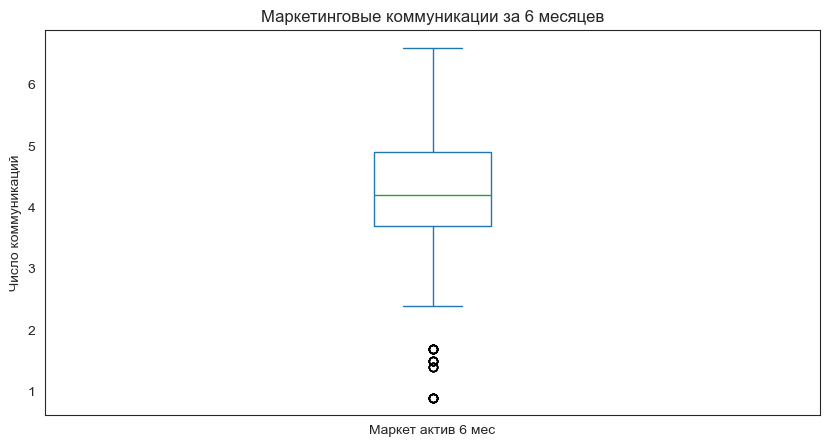

In [780]:
plt.rcParams['figure.figsize']=(10,5)
plt.title('Маркетинговые коммуникации за 6 месяцев')
plt.ylabel('Число коммуникаций')
df_market['Маркет актив 6 мес'].plot(kind='box')
plt.show()

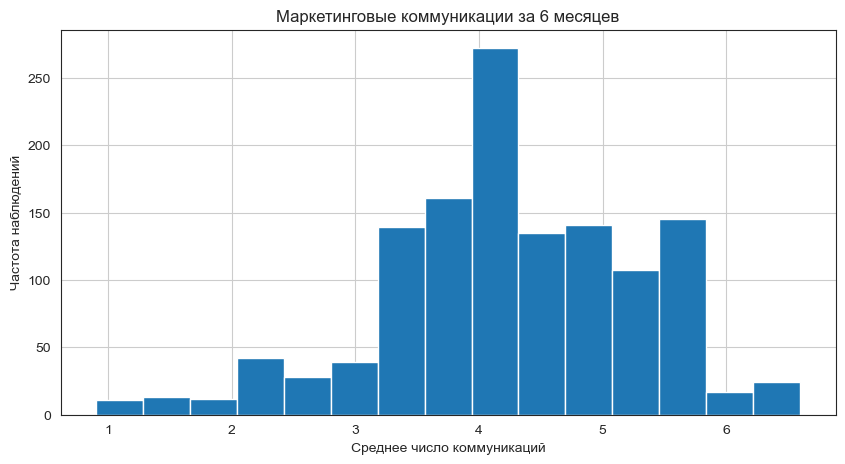

In [781]:
plt.title('Маркетинговые коммуникации за 6 месяцев')
plt.xlabel('Среднее число коммуникаций')
plt.ylabel('Частота наблюдений')
df_market['Маркет актив 6 мес'].hist(bins=15)
plt.show()

Несмотря на обозначенные выбросы на графике боксплот, эти значения выглядят логически объяснимыми, например,  возможно клиент ограничил некоторые каналы коммуникации 

### Маркетинговые коммуникации за текущий месяц


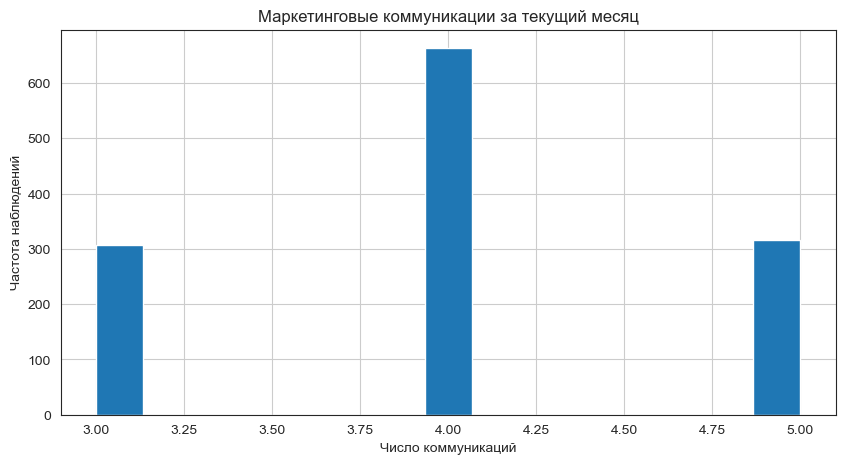

In [784]:
plt.title('Маркетинговые коммуникации за текущий месяц')
plt.xlabel('Число коммуникаций')
plt.ylabel('Частота наблюдений')
df_market['Маркет актив тек мес'].hist(bins=15)
plt.show()

Графики получились малоинформативными, с половиной клиентов связывались четыре раза, а со второй половиной, либо три, либо пять

### Число дней с даты регистрации

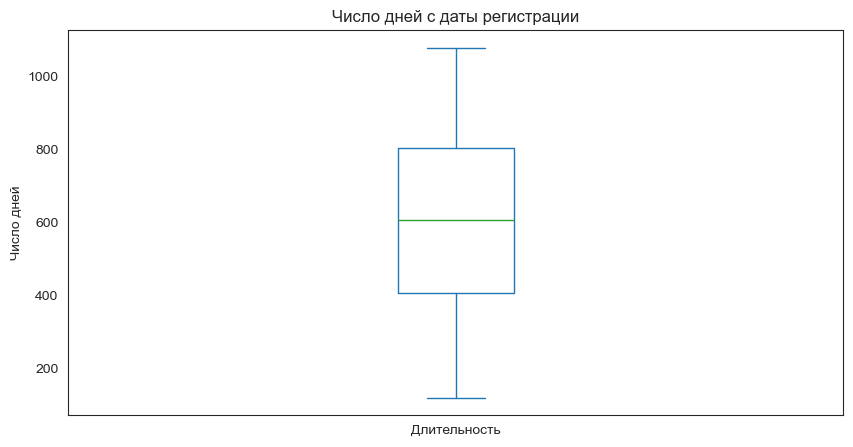

In [787]:
plt.title('Число дней с даты регистрации')
plt.ylabel('Число дней')
df_market['Длительность'].plot(kind='box')
plt.show()

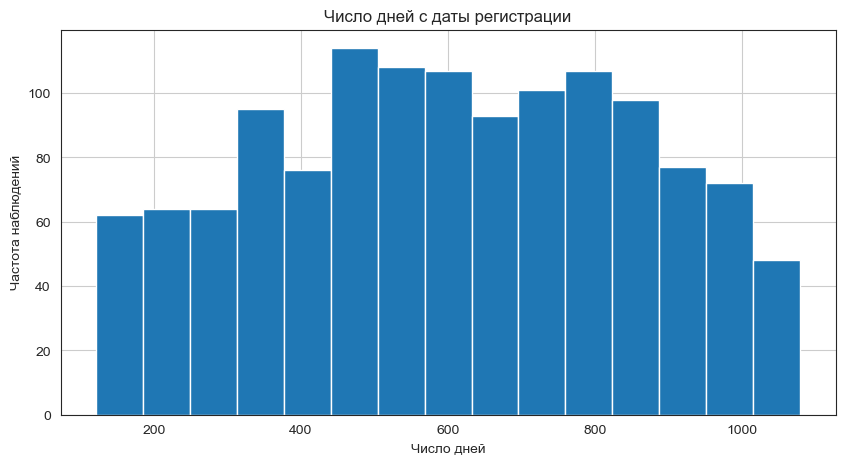

In [788]:
plt.title('Число дней с даты регистрации')
plt.xlabel('Число дней')
plt.ylabel('Частота наблюдений')
df_market['Длительность'].hist(bins=15)
plt.show()

В этих данных, мы видим приблизительно нормальное распределение со средним значением в районе 600 дней 

### Акционные покупки	

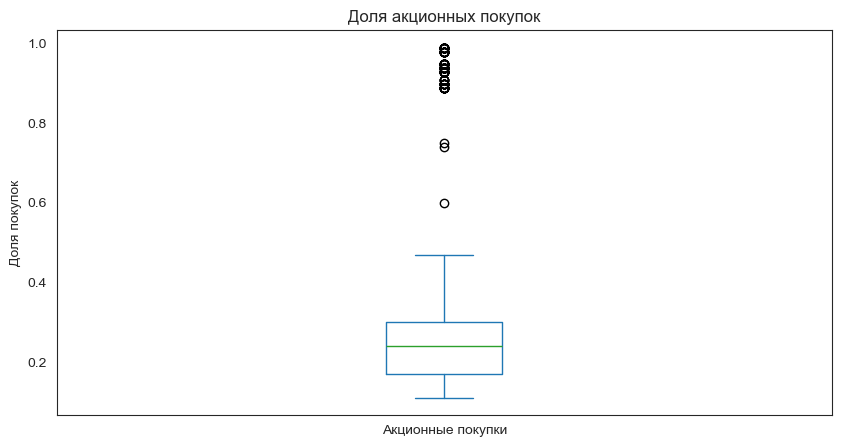

In [791]:
plt.title('Доля акционных покупок')
plt.ylabel('Доля покупок')
df_market['Акционные покупки'].plot(kind='box')
plt.show()

Боксплот показывает выбросы в верхней части диапазона, но при этом, можно предположить, что действительно существуют клиенты, покупающие на сайте почти исключительно акционные товары

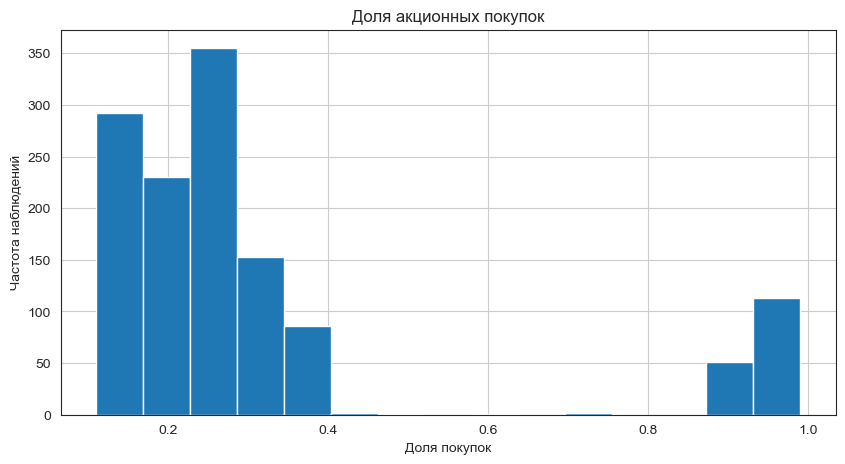

In [793]:
plt.title('Доля акционных покупок')
plt.xlabel('Доля покупок')
plt.ylabel('Частота наблюдений')
df_market['Акционные покупки'].hist(bins=15)
plt.show()

На гистограмме мы действительно видим бимодальное распределение доли покупок акционных товаров со вторым, небольшим, пиком, в районе 0.9

### Средний просмотр категорий за визит	

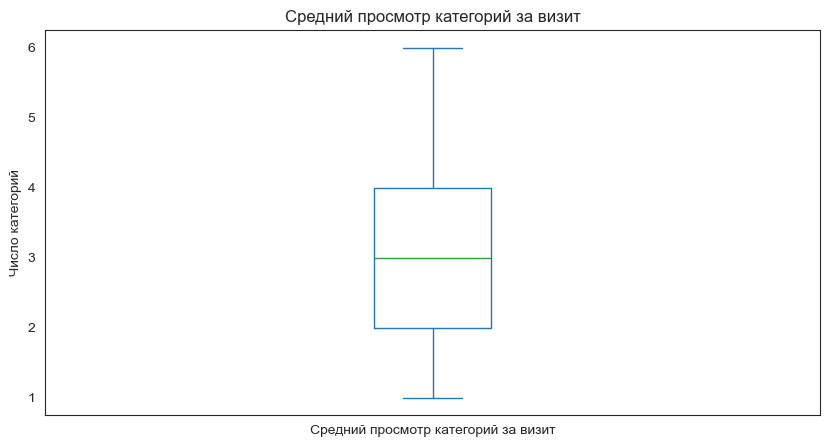

In [796]:
plt.title('Средний просмотр категорий за визит')
plt.ylabel('Число категорий')
df_market['Средний просмотр категорий за визит'].plot(kind='box')
plt.show()

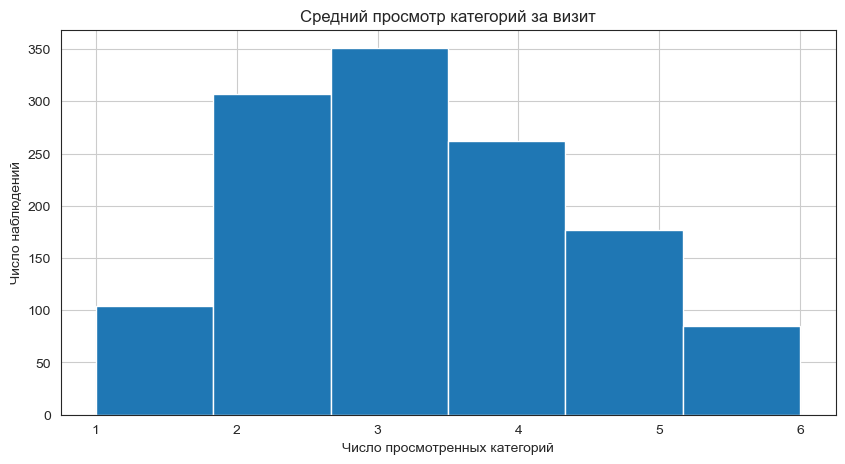

In [797]:
plt.title('Средний просмотр категорий за визит')
plt.xlabel('Число просмотренных категорий')
plt.ylabel('Число наблюдений')
df_market['Средний просмотр категорий за визит'].hist(bins=6)
plt.show()

Мы видим приблизительно нормальное распределение числа просмотров категорий с небольшим скосом вправо

### Неоплаченные продукты за последний квартал

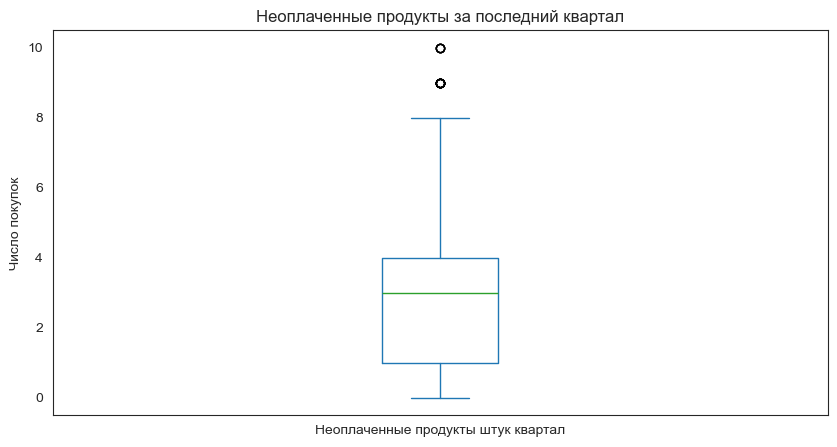

In [800]:
plt.title('Неоплаченные продукты за последний квартал')
plt.ylabel('Число покупок')
df_market['Неоплаченные продукты штук квартал'].plot(kind='box')
plt.show()

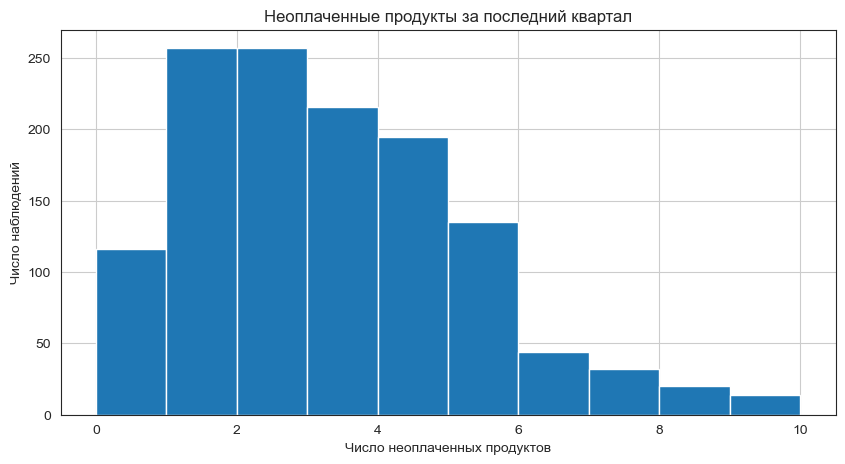

In [801]:
plt.title('Неоплаченные продукты за последний квартал')
plt.xlabel('Число неоплаченных продуктов')
plt.ylabel('Число наблюдений')
df_market['Неоплаченные продукты штук квартал'].hist(bins=10)
plt.show()

На гистограмме мы видим скос вправо, дальнюю часть которого боксплот идентифицировал как выбросы. При этом, логически, максимальные значения не выглядят нереалистично и, скорее всего, данные достоверны

### Ошибки сервиса	

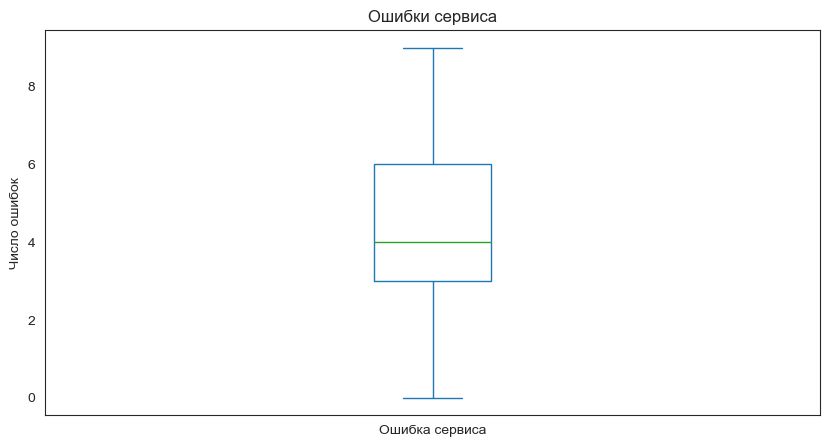

In [804]:
plt.title('Ошибки сервиса')
plt.ylabel('Число ошибок')
df_market['Ошибка сервиса'].plot(kind='box')
plt.show()

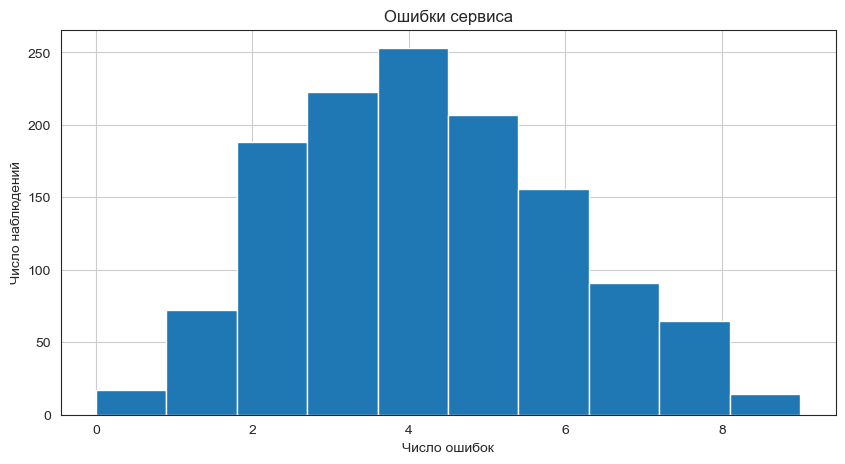

In [805]:
plt.title('Ошибки сервиса')
plt.xlabel('Число ошибок')
plt.ylabel('Число наблюдений')
df_market['Ошибка сервиса'].hist(bins=10)
plt.show()

На гистограмме мы видим приблизительно нормальное распределение

### Число страниц за визит

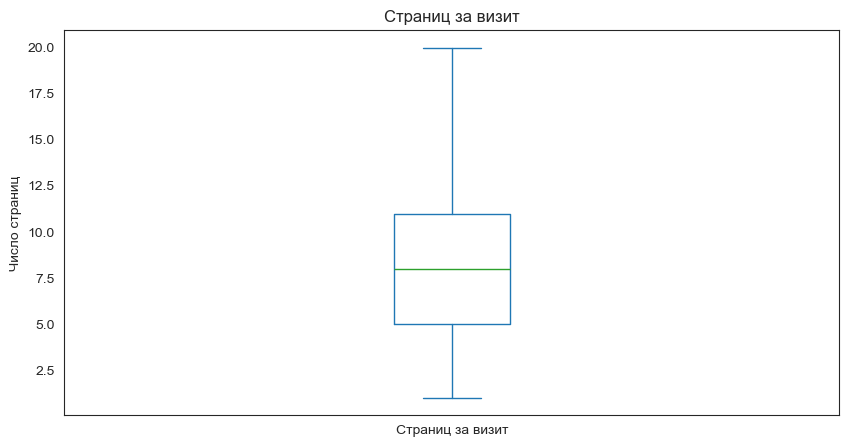

In [808]:
plt.title('Страниц за визит')
plt.ylabel('Число страниц')
df_market['Страниц за визит'].plot(kind='box')
plt.show()

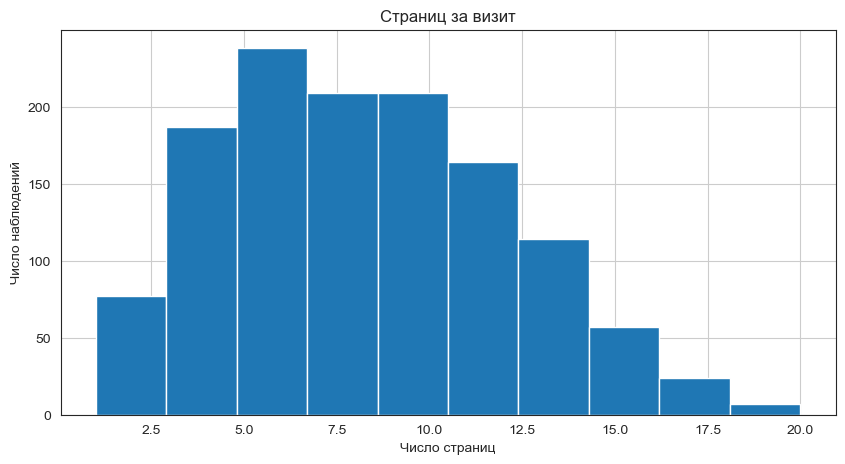

In [809]:
plt.title('Страниц за визит')
plt.xlabel('Число страниц')
plt.ylabel('Число наблюдений')
df_market['Страниц за визит'].hist(bins=10)
plt.show()

На гистограмме мы видим приблизительно нормальное распределение с небольшим скосом вправо

### Выручка

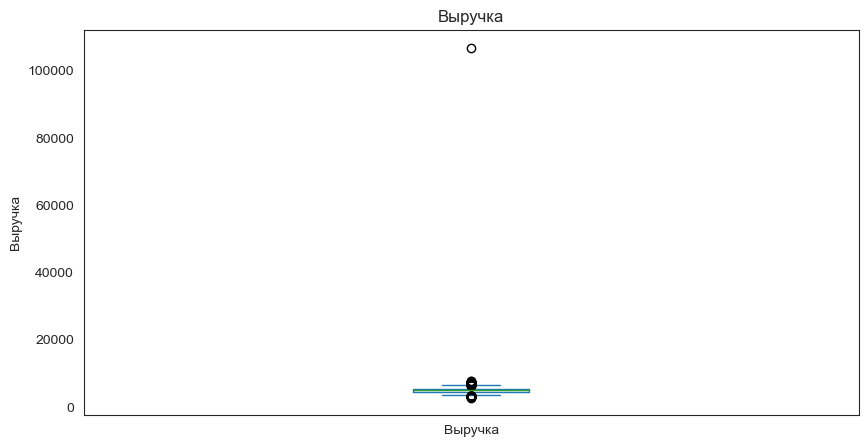

In [812]:
plt.title('Выручка')
plt.ylabel('Выручка')
df_m_money['Выручка'].plot(kind='box')
plt.show()

Мы видим одно наблюдение, в районе 100 тыс., которое существенно влияет на график 

In [814]:
df_m_money[df_m_money['Выручка']>100000]['id']

98    215380
Name: id, dtype: int64

Проверим, повлияло ли это значение на прибыль

In [816]:
print(df_money['Прибыль'].mean().round(2))
print(df_money[df_money['id']==215380]['Прибыль'].round(2))

4.0
32    3.88
Name: Прибыль, dtype: float64


Выручка этого пользователя не повлияла на прибыль, скорее всего, значение недостоверно. Пока нам удалось сохранить почти все строки, удаление еще одного пользователя на результатах существенно не скажется.

In [818]:
df_market.drop(index=df_market[df_market['id']==215380].index, inplace=True)
df_money.drop(index=df_money[df_money['id']==215380].index, inplace=True)
df_m_money.drop(index=df_m_money[df_m_money['id']==215380].index, inplace=True)
df_time.drop(index=df_time[df_time['id']==215380].index, inplace=True)

Для построения графиков, выручка 0 тоже не слишком информативна, учитывая небольшое число наблюдений 

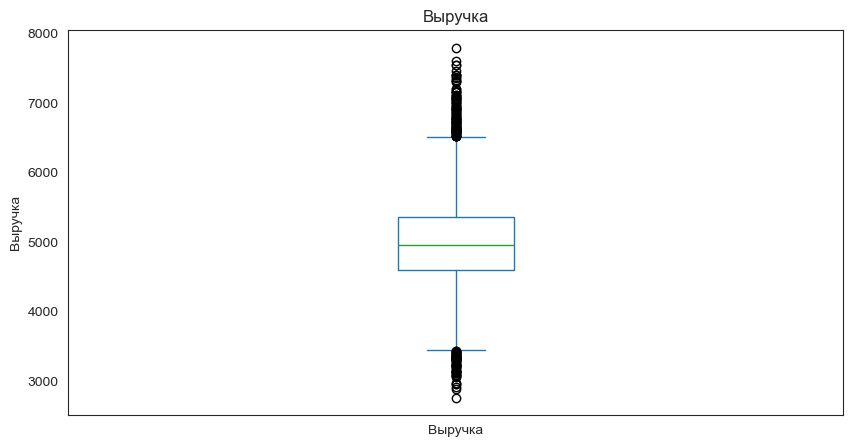

In [820]:
plt.title('Выручка')
plt.ylabel('Выручка')
df_m_money[(df_m_money['Выручка']<100000) & (df_m_money['Выручка']>0)]['Выручка'].plot(kind='box')
plt.show()

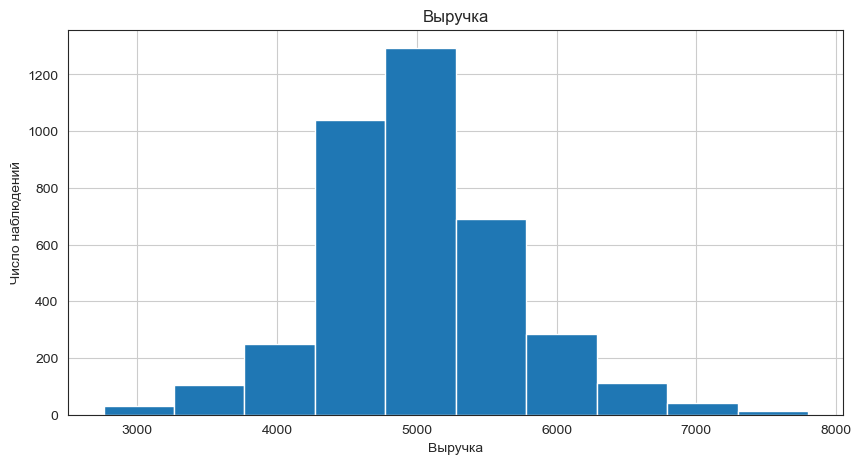

In [821]:
plt.title('Выручка')
plt.xlabel('Выручка')
plt.ylabel('Число наблюдений')
df_m_money[(df_m_money['Выручка']<100000) & (df_m_money['Выручка']>0)]['Выручка'].hist(bins=10)
plt.show()

Несмотря на то, что боксплот показывает выбросы и сверху и снизу, если мы отбросим максимальное значение и шесть наблюдений без выручки, гистограмма показывает нормальное распределение

### Минуты на сайте 

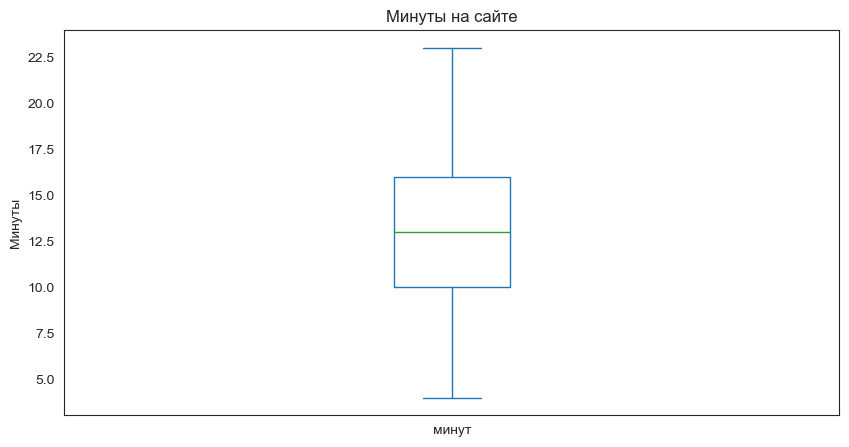

In [824]:
plt.title('Минуты на сайте')
plt.ylabel('Минуты')
df_time['минут'].plot(kind='box')
plt.show()

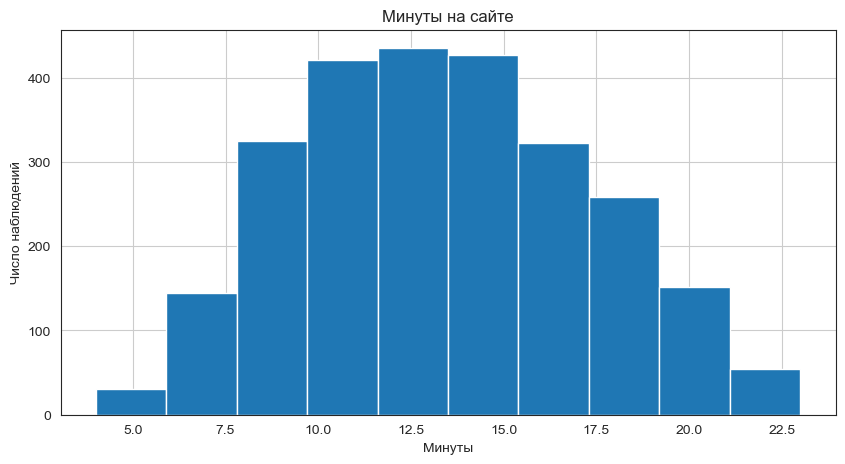

In [825]:
plt.title('Минуты на сайте')
plt.xlabel('Минуты')
plt.ylabel('Число наблюдений')
df_time['минут'].hist(bins=10)
plt.show()

На гистограмме мы видим нормальное распределение, боксплот выбросов не показал 

### Прибыль

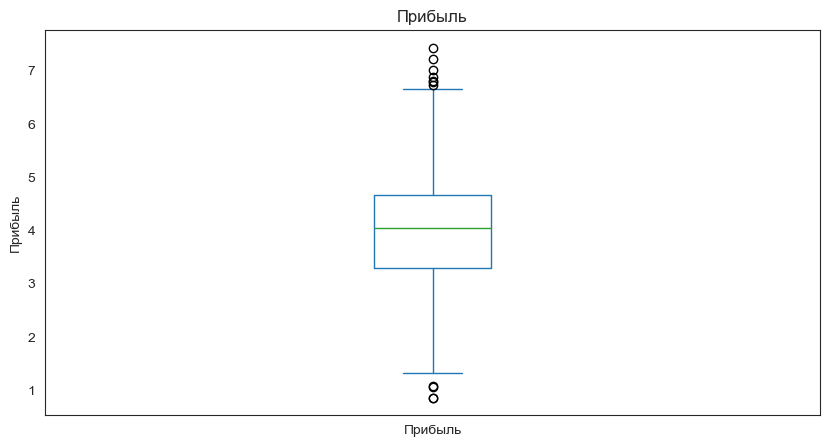

In [828]:
plt.title('Прибыль')
plt.ylabel('Прибыль')
df_money['Прибыль'].plot(kind='box')
plt.show()

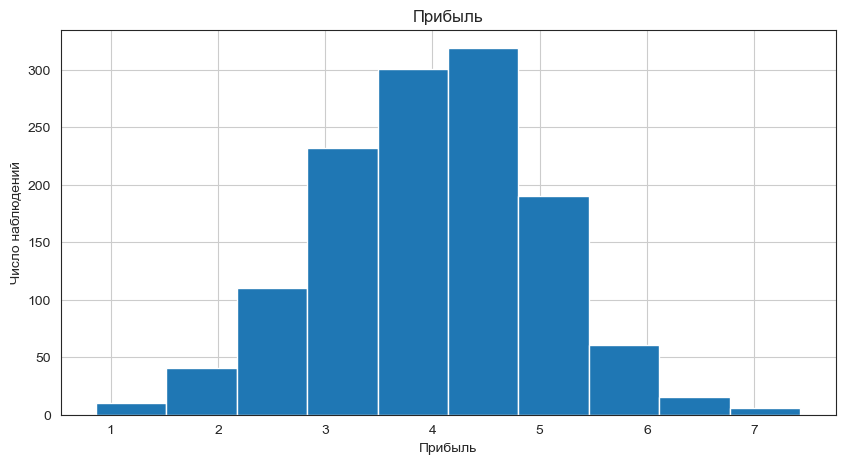

In [829]:
plt.title('Прибыль')
plt.xlabel('Прибыль')
plt.ylabel('Число наблюдений')
df_money['Прибыль'].hist(bins=10)
plt.show()

Боксплот показал выбросы как сверху, так и снизу, но на гистограмме мы видим нормальное распределение

Перейдем к рассмотрению категориальных признаков. Для бинарных признаков мы будем использовать круговые диаграммы, как более наглядные

### Покупательская активность

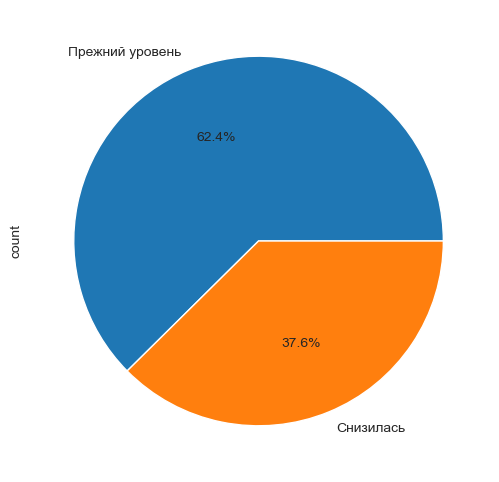

In [833]:
plt.title('')
df_market['Покупательская активность'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,6))
plt.show()

Покупательская активность — целевой признак. Распределение между мажорным и минорным классом достаточно равномерное 

### Тип сервиса

In [836]:
df_market['Тип сервиса'].replace('стандартт', 'стандарт', inplace=True)
df_market['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

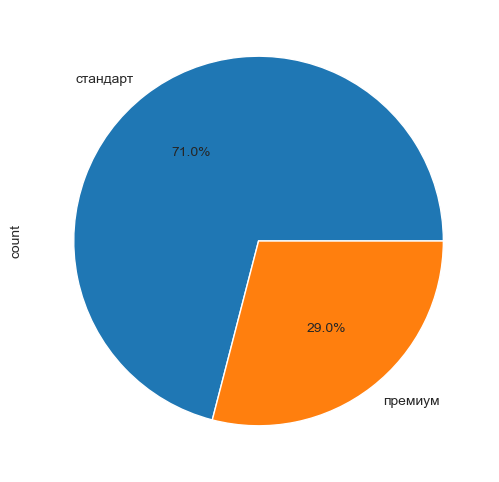

In [837]:
plt.title('')
df_market['Тип сервиса'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,6))
plt.show()

### Разрешение на коммуникацию

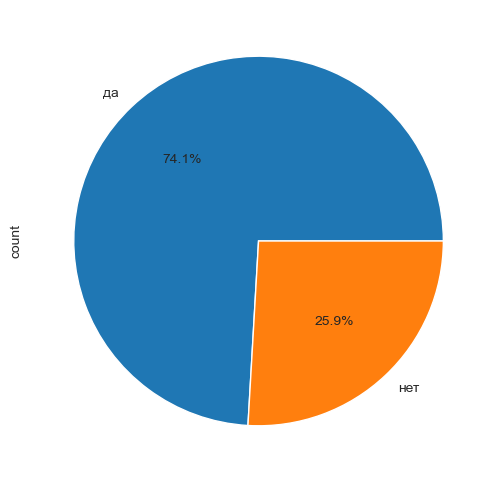

In [839]:
plt.title('')
df_market['Разрешить сообщать'].value_counts().plot.pie(autopct='%.1f%%', figsize=(6,6))
plt.show()

### Популярная категория

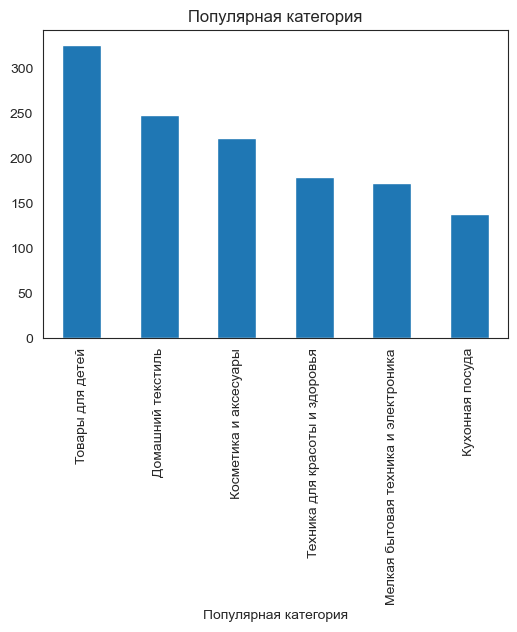

In [841]:
plt.title('Популярная категория')
df_market['Популярная категория'].value_counts().plot.bar(figsize=(6,4))
plt.show()

Распределение между популярными категориями достаточно равномерное, но товары для детей лидируют с некоторым отрывом

### Выводы из исследовательского анализа 

В категориальных признаках ничего необычного мы не видим, при этом, популярные категории можно в общем описать как товары для детей, дома и красоты.

Доля пользователей со снизившейся покупательной активностью составляет почти 40%, что, на первый взгляд, кажется высоким уровнем, но для наших целей это скорее удобно. Достаточно равномерное распределение данных между мажорным и минорным классом целевого признака позволяет нам использовать данные без дополнительного взвешивания классов. Учитывая, что в описании задач не был отдан приоритет ошибкам первого или второго типа и для оценки мы можем использовать метрику ROC_AUC, существующее распределение выглядит приемлемым и мы можем обойтись простой стратификацией

## Объединение таблиц

### Обработка таблиц с разбивкой по месяцам

Для объединения таблиц мы можем использовать уникальный идентификатор 'id'. В таблицах df_m_money и df_time на каждый id приходится по несколько записей, в зависимости от месяца. В итоговой таблице мы запишем выручку и время в отдельные столбцы для каждого месяца

In [848]:
df_m_money_1 = pd.DataFrame()
df_m_money['выручка 0'] = df_m_money[df_m_money['Период']=='текущий_месяц']['Выручка']
df_m_money['выручка -1'] = df_m_money[df_m_money['Период']=='предыдущий_месяц']['Выручка']
df_m_money['выручка -2'] = df_m_money[df_m_money['Период']=='препредыдущий_месяц']['Выручка']
df_m_money_1 = df_m_money[['id','выручка 0', 'выручка -1', 'выручка -2']].copy()
df_m_money_1 = df_m_money_1.groupby('id').agg(
    {'выручка 0' : 'max',
     'выручка -1' : 'max',
     'выручка -2' : 'max',
    }).reset_index()
df_m_money_1.head(5)

,id,выручка 0,выручка -1,выручка -2
0,215349,4971.6,5216.0,4472.0
1,215350,5058.4,5457.5,4826.0
2,215351,6610.4,6158.0,4793.0
3,215352,5872.5,5807.5,4594.0
4,215353,5388.5,4738.5,5124.0


In [849]:
dfm = df_m_money.pivot_table(index = 'id',
                             columns=['Период'], 
                             values = ['Выручка'], 
                             aggfunc={'Выручка':'max'})
dfm.columns=dfm.columns.droplevel(0)
dfm

Период,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
...,...,...,...
216643,3664.0,4704.0,4741.7
216644,4729.0,5299.0,5353.0
216645,5160.0,5334.0,5139.2


Проверим получившуюся таблицу на втором id

In [851]:
df_m_money[df_m_money['id']==215349]

,id,Период,Выручка,выручка 0,выручка -1,выручка -2
3,215349,препредыдущий_месяц,4472.0,NaN,NaN,4472.0
4,215349,текущий_месяц,4971.6,4971.6,NaN,NaN
5,215349,предыдущий_месяц,5216.0,NaN,5216.0,NaN


Посмотрим, существуют ли в таблице клиенты, ничего не купившие за последние три месяца

In [853]:
len(df_m_money_1[df_m_money_1['выручка 0']+df_m_money_1['выручка -1']+df_m_money_1['выручка -2']==0])

0

Таких клиентов не обнаружено 

Проведем такую же операцию с минутами

In [856]:
df_time_1 = pd.DataFrame()
df_time['Минуты 0'] = df_time[df_time['Период']=='текущий_месяц']['минут']
df_time['Минуты -1'] = df_time[df_time['Период']=='предыдцщий_месяц']['минут']
df_time_1 = df_time[['id','Минуты 0', 'Минуты -1']].copy()
df_time_1 = df_time_1.groupby('id').agg(
    {'Минуты 0' : 'max',
     'Минуты -1' : 'max',
     }).reset_index()
df_time_1.head(5)

,id,Минуты 0,Минуты -1
0,215349,10.0,12.0
1,215350,13.0,8.0
2,215351,13.0,11.0
3,215352,11.0,8.0
4,215353,10.0,10.0


In [857]:
df_time[df_time['id']==215348]

,id,Период,минут,Минуты 0,Минуты -1


In [858]:
df_market.shape

(1285, 13)

### Объединение таблиц

Объединяем данные по ключам из левого датафрейма

In [861]:
df_temp = df_market.merge(df_m_money_1, on='id', how='left')
df = df_temp.merge(df_time_1, on='id', how='left')
df.shape

(1285, 18)

In [862]:
df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет актив 6 мес,Маркет актив тек мес,Длительность,Акционные покупки,Популярная категория,Средний просмотр категорий за визит,Неоплаченные продукты штук квартал,Ошибка сервиса,Страниц за визит,выручка 0,выручка -1,выручка -2,Минуты 0,Минуты -1
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,5216.0,4472.0,10.0,12.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,5457.5,4826.0,13.0,8.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,6158.0,4793.0,13.0,11.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,5807.5,4594.0,11.0,8.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,4738.5,5124.0,10.0,10.0


В объединенной таблице мы сохранили по одной строке для каждого id и взяли максимальное значение для каждого из новых столбцов с этим id через agg

## Корреляционный анализ

Корреляцию количественных параметров мы можем предварительно оценить через матрицу корреляций и диаграммы рассеивания

### Матрицы корреляций 

Построим матрицу корреляции Phi_k

interval columns not set, guessing: ['Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность', 'Акционные покупки', 'Средний просмотр категорий за визит', 'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит', 'выручка 0', 'выручка -1', 'выручка -2', 'Минуты 0', 'Минуты -1']


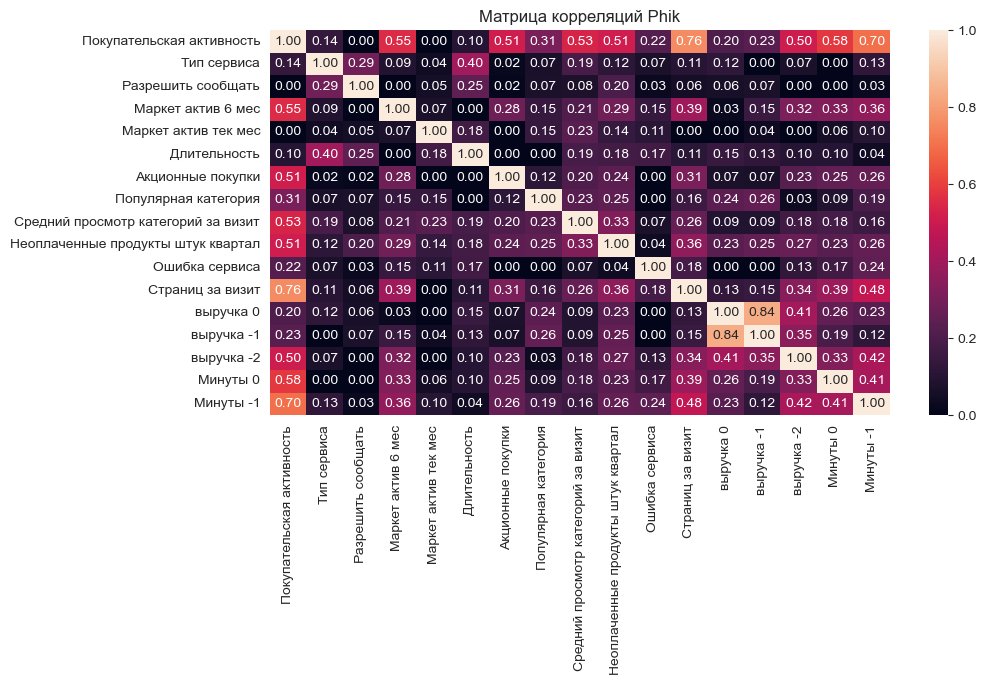

In [868]:
sns.heatmap(df.drop('id', axis=1).phik_matrix(), annot=True, fmt='.2f')
plt.title('Матрица корреляций Phik')
plt.show()

Матрица корреляций Phi_k позволяет оценить взаимосвязь не только между количественными признаками, что важно, учитывая, что целевой признак - покупательская активность. Также Phi_k может улавливать нелинейную взаимосвязь между признаками.

Согласно шкале Чеддока, заметная корреляция покупательской активности есть со среднемесячным числом маркетинговых коммуникаций за последние 6 месяцев, числом акционных покупок, числом средних просмотров категорий за визит, числом неоплаченных продуктов за квартал, выручкой -1 и -2 и минут на сайте 0 и -1. Число страниц просмотренных, в среднем, за визит — единственный признак с высокой корреляцией.

Коллинеарности признаков не обнаружено.

Интервальные колонки были определены верно, сохраним их на будущее

### Диаграммы рассеивания 

Для построения диаграмм рассеивания, возьмем за основу цвет точек с покупательской активностью и ось х - среднее число страниц за визит, как признак с самой высокой корреляцией с целевым

Для построения диаграмм рассеивания уберем интервальные колонки с небольшим дискретным диапазоном значений 

In [873]:
df_numeric = ['Маркет актив 6 мес', 'Длительность', 'Акционные покупки',
             'Неоплаченные продукты штук квартал','Ошибка сервиса', 'выручка 0',
             'выручка -1', 'выручка -2', 'Минуты 0', 'Минуты -1']

In [874]:
def scat(col0, col1, col2):
    for c in df[col0].unique():
        plt.scatter(df[df[col0]==c][col1], df[df[col0]==c][col2],label = f'{col0} - {c}', alpha=0.3)
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend()
    plt.show()

Исходя из данных матрицы Phik мы ожидаем, что синие точки будут расположены преимущественно в левой части диаграммы рассеивания, но мы можем посмотреть "липнут" ли они к нижней или верхней части графика и форму получившейся кривой

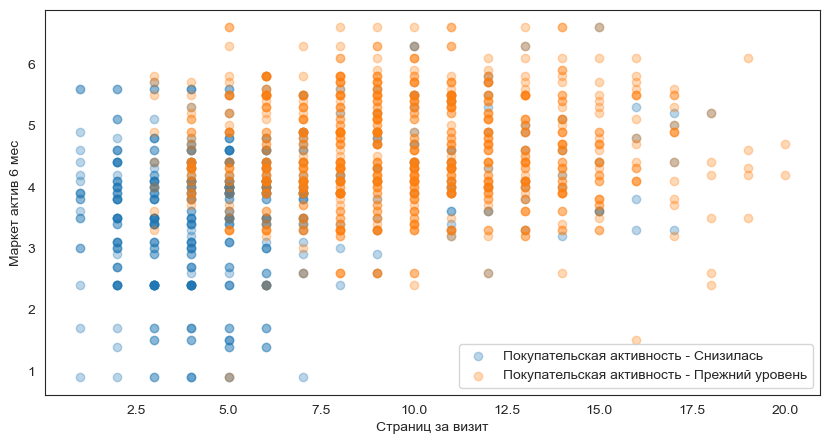

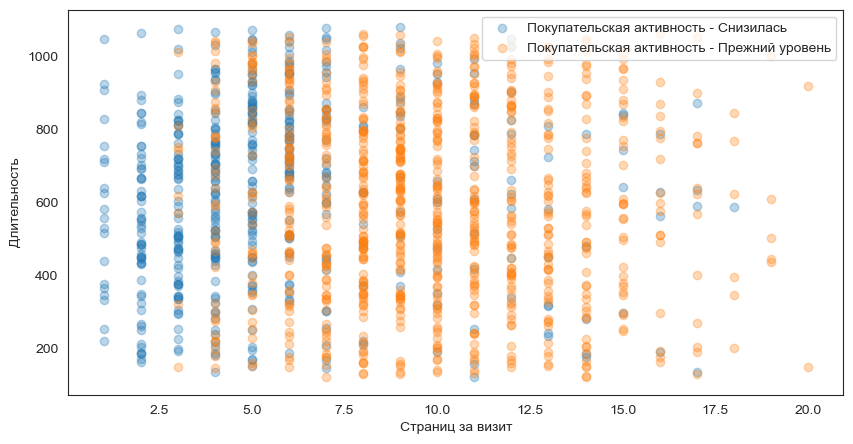

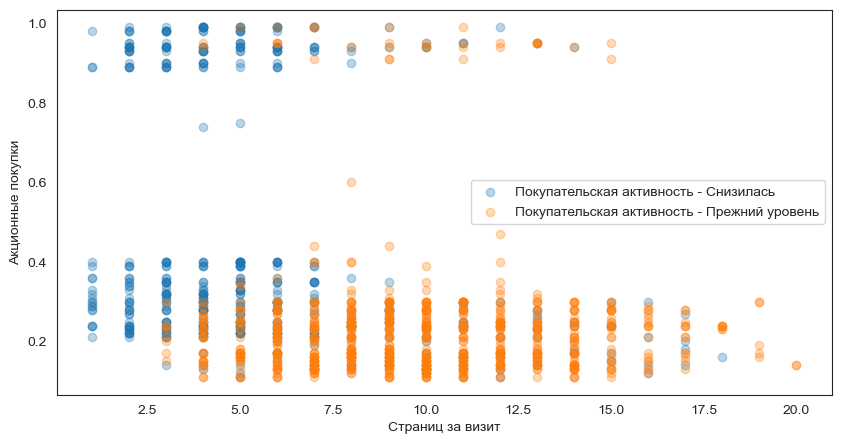

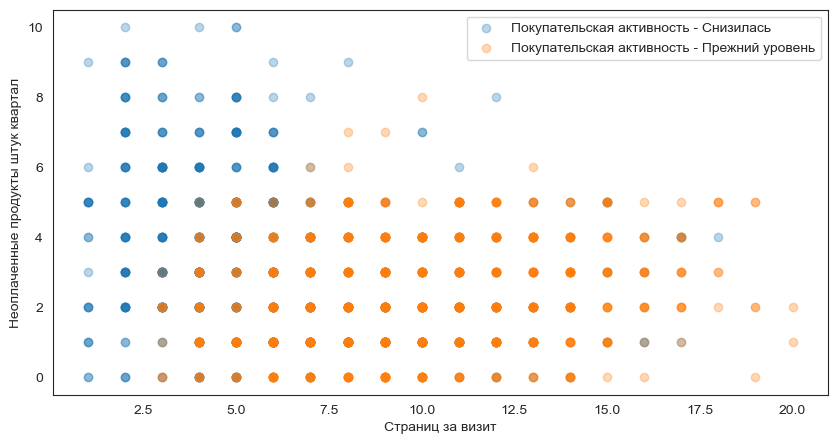

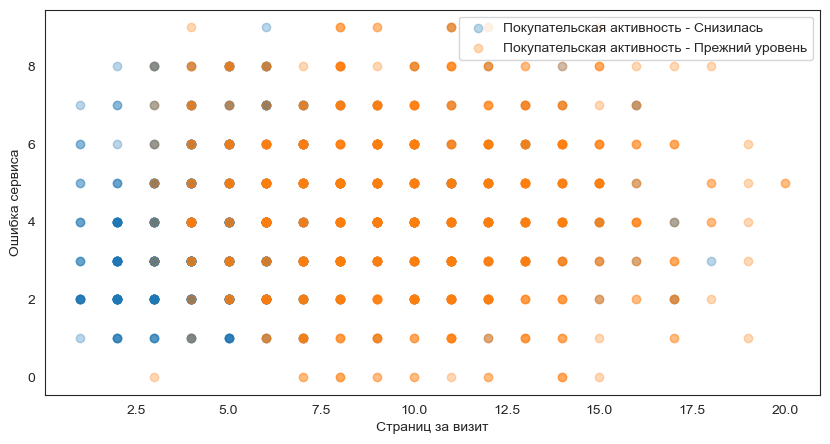

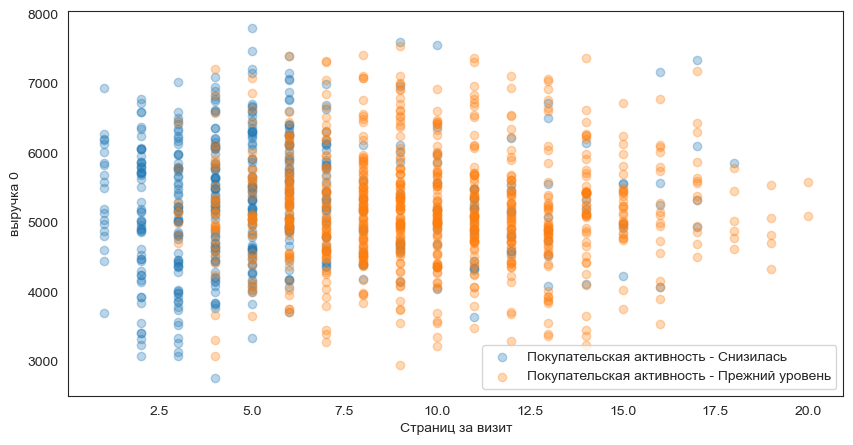

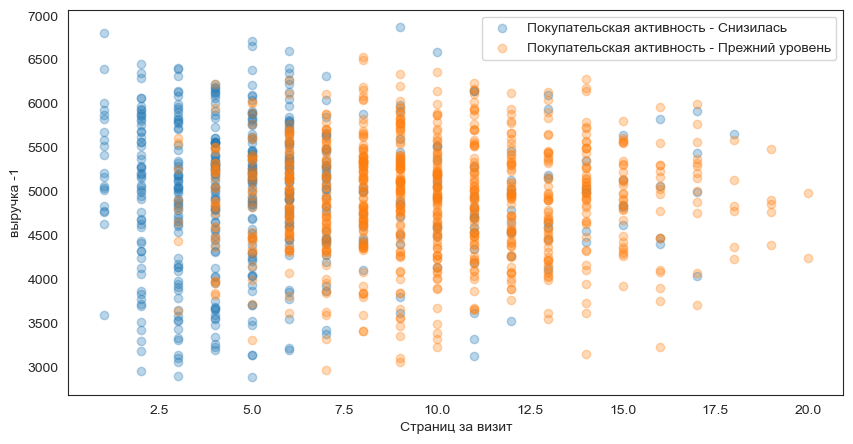

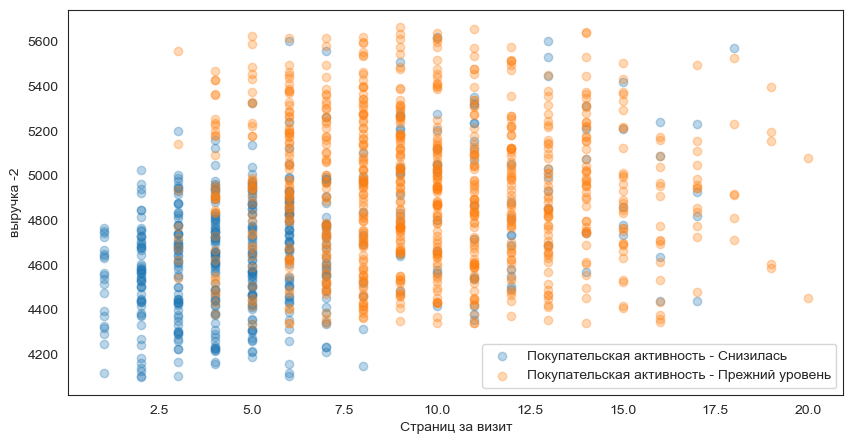

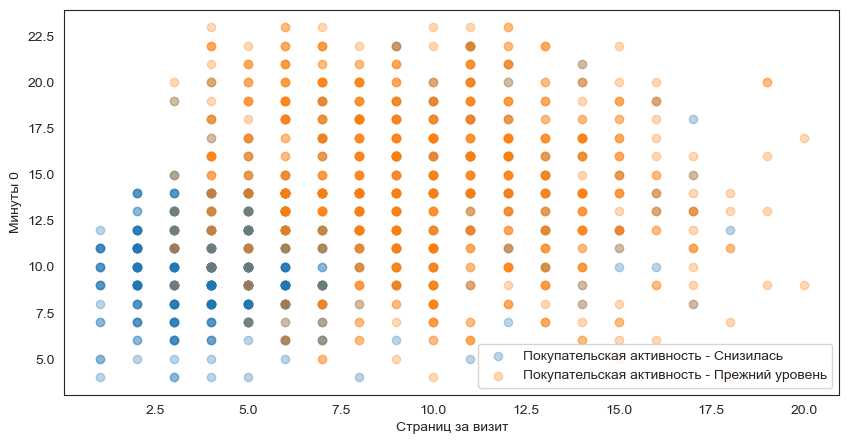

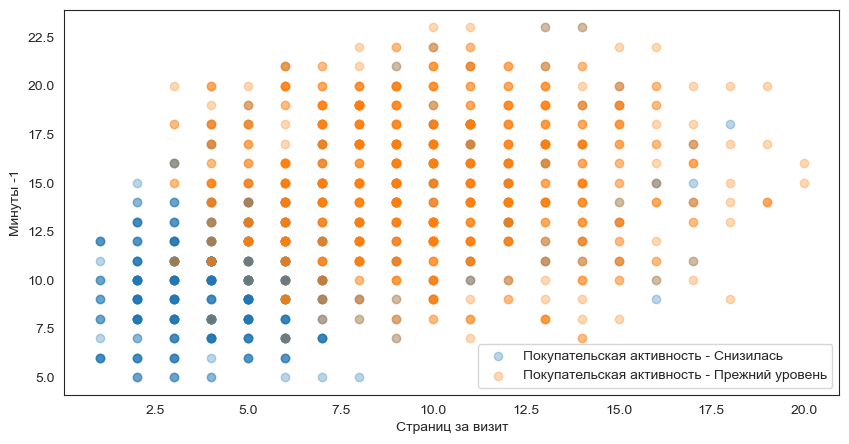

In [876]:
for q1 in df_numeric:
    scat('Покупательская активность', 'Страниц за визит', q1)
    print()

По результатам, мы видим отчетливое разделение доли акционных покупок на две группы, с преобладанием клиентов со снизившейся активностью в верхних значениях.
В диаграмме с числом неоплаченных покупок мы также видим снижение покупательской активности в верхней части диапазона.
Ошибки сервиса не кажутся существенным фактором, влияющем на активность клиентов.
Маркетинговые и коммуникационные показатели, похоже, положительно коррелированны с вероятностью удержания активности.

### Общие наблюдения

Данные матриц корреляции и диаграмм рассеивания дают нам приблизительное представление о важности признаков, которые мы ожидаем увидеть в моделях. Вероятно, значительная часть признаков получит небольшие веса или будет удалена при помощи регуляризации. Отбор признаков мы будем проводить в автоматическом режиме при переборе моделей через С или аналоги, как максимальное количество признаков в DecissionTreeClassifier 

## Пайплайны

### Подготовка данных

Для начала, разделим датафрейм на выборки со стратификацией и преобразуем целевой признак в цифровой формат, чтобы работать с ним могли все модели

In [883]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Покупательская активность', 'id'], axis=1),
    df['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df['Покупательская активность'])

In [884]:
lbl = LabelEncoder()
y_train = lbl.fit_transform(y_train)
y_test = lbl.transform(y_test)

In [885]:
print("Классы LabelEncoder:", lbl.classes_)

Классы LabelEncoder: ['Прежний уровень' 'Снизилась']


Составим список признаков для кодировщиков и масштабирования в пайплайне 

In [887]:
ohe_columns = [
    'Разрешить сообщать',
    'Популярная категория'
]

ord_columns = [
    'Тип сервиса'    
]

num_columns = [
    'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность',
    'Акционные покупки', 'Средний просмотр категорий за визит', 
    'Неоплаченные продукты штук квартал', 'Ошибка сервиса', 'Страниц за визит', 
    'выручка 0', 'выручка -1', 'выручка -2', 'Минуты 0', 'Минуты -1'
]

### Составление пайплайнов 

Составим отдельные пайплайны для трех категорий признаков и объединим его через ColumnTransformer

In [890]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(handle_unknown='error', drop='first')
        )
    ]
)


In [891]:
ord_pipe = Pipeline(
    [
        (
            'SimpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'SimpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [892]:
preprocessing = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Объединим в финальный пайплайн подготовку данных и саму модель

In [894]:
warnings.filterwarnings('ignore')

In [895]:
pipe_final = Pipeline([
    ('preprocessor', preprocessing),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Составим словарь для поиска лучших гиперпараметров случайной выборкой с кросс-валидацией 

In [897]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'model': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'model__max_depth': range(5,15),
        'model__max_features': range(10,20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': range(5, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'model': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
            penalty='l1'
        )],
        'model__C': [0.1,0.2,0.5,1,2,5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'model': [SVC(probability=True,
            random_state=RANDOM_STATE
        )],
        'model__kernel': ['poly','rbf', 'sigmoid'],
        'model__C': [0.1,0.2,0.5,1,2,5],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

### Подбор модели

Запустим подбор параметров, с огранчением итераций 60. При cv=5 это суммарно 300 циклов, GridSearchCV, в данном случае, займет слишком много времени

Для выбора метрики подбора модели, нам необходимо учитывать, что три из четырех кандидатов по умолчанию возвращают дискретное предсказание метки класса, а не вероятность. Хотя для всех моделей можно получить оценку proba, часто это подразумевает наличие специфичных дисбалансов. Так DecisionTreeClassifier на больших датафреймах часто выдает листья с малым количеством сэмплов, что может приводить к переобучению и поляризации proba. В KNN вероятность рассчитывается на основании доли классов среди соседних значений и может сильно зависеть от выбора числа соседних значений при классификации и используемой метрике расстояния между наблюдениями. 
В качестве простой и универсальной метрики для всех моделей, мы будем использовать f1_score, учитывая, что по заданию, нам не был указан приоритет precision или recall, а f1_score сбалансировано учитывает обе эти метрики.

In [901]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0,
    n_iter=200
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_.round(2))

y_test_pred = randomized_search.predict(X_test)
print(f'Метрика f1_score на тестовой выборке: {f1_score(y_test, y_test_pred).round(2)}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                     

Посмотрим на список из пяти лучших результатов по среднему f1_score при кросс-валидации

In [903]:
pd.set_option('display.max_colwidth', None)

In [904]:
result = pd.DataFrame(randomized_search.cv_results_)
best_params = result[
    ['rank_test_score', 'param_model', 'mean_test_score','params']
].sort_values('rank_test_score').head()
best_params

,rank_test_score,param_model,mean_test_score,params
122,1,"SVC(probability=True, random_state=42)",0.852183,"{'preprocessor__num': RobustScaler(), 'model__kernel': 'rbf', 'model__C': 2, 'model': SVC(probability=True, random_state=42)}"
154,2,"SVC(probability=True, random_state=42)",0.842392,"{'preprocessor__num': StandardScaler(), 'model__kernel': 'rbf', 'model__C': 5, 'model': SVC(probability=True, random_state=42)}"
153,3,"SVC(probability=True, random_state=42)",0.839996,"{'preprocessor__num': StandardScaler(), 'model__kernel': 'rbf', 'model__C': 0.2, 'model': SVC(probability=True, random_state=42)}"
19,4,"SVC(probability=True, random_state=42)",0.838198,"{'preprocessor__num': StandardScaler(), 'model__kernel': 'rbf', 'model__C': 0.1, 'model': SVC(probability=True, random_state=42)}"
26,5,"SVC(probability=True, random_state=42)",0.837372,"{'preprocessor__num': MinMaxScaler(), 'model__kernel': 'rbf', 'model__C': 5, 'model': SVC(probability=True, random_state=42)}"


У нас получилось два типа модели, с не слишком отличающимися результатами по кросс валидации, можно сказать, что смещение примерно одинаковое

## Анализ важности признаков

### Первичный обзор моделей

In [908]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('SimpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Тип сервиса']),
                                                 ('num', RobustScaler(),
                                                  ['Маркет актив 6 мес',
                                                   'Маркет актив тек мес',
                                                   'Длительность',
                                                   'Акционные покупки',
                                                   'Средний просмотр категорий '
                                                   'за визит',
                                                   'Неоплаченные продукты штук '
                                                   'квартал',
                                                   'Ошибка сервиса',
                                                   'Страниц за визит',
                                                   'выручка 0', 'выручка -1',
                                                   'выручка -2', 'Минуты 0',
                                                   'Минуты -1'])])),
                ('model', SVC(C=2, probability=True, random_state=42))])

Выведем параметры второй модели из списка лучших по кросс-валидации

In [910]:
second_best_params = best_params.iloc[1]['params']
second_best_params

{'preprocessor__num': StandardScaler(),
 'model__kernel': 'rbf',
 'model__C': 5,
 'model': SVC(probability=True, random_state=42)}

<!-- third_best_params = best_params.iloc[2]['params']
third_best_params -->

подготовим две версии preprocessing с разными скейлерами и две модели

In [913]:
preprocessing_1 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [914]:
preprocessing_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

<!-- preprocessing_3 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', RobustScaler(), num_columns)
    ], 
    remainder='passthrough'
)  -->

In [916]:
preprocessing_1.fit(X_train)
feature_names = preprocessing_1.get_feature_names_out()
X_train_1 = preprocessing_1.transform(X_train)
X_test_1 = preprocessing_1.transform(X_test)
X_train_1 = pd.DataFrame(X_train_1, columns=feature_names)
X_test_1 = pd.DataFrame(X_test_1, columns=feature_names)

<!-- X_train_2 = preprocessing_1.transform(X_train)
X_test_2 = preprocessing_1.transform(X_test)
X_train_2 = pd.DataFrame(X_train_2, columns=feature_names)
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names) -->

In [918]:
preprocessing_2.fit(X_train)
feature_names = preprocessing_2.get_feature_names_out()
X_train_2 = preprocessing_2.transform(X_train)
X_test_2 = preprocessing_2.transform(X_test)
X_train_2 = pd.DataFrame(X_train_2, columns=feature_names)
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

Мы знаем, что модели показывают примерно одинаковое смещение при кросс-валидации. Оценим их разброс на тестовой выборке

<!-- model_1 = KNeighborsClassifier(n_neighbors=10)
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_test_1)
print(f'Метрика ROC-AUC первой модели на тестовой выборке: {f1_score(y_test, y_pred_1).round(2)}') -->

In [921]:
model_1 = SVC(probability=True, random_state=RANDOM_STATE, kernel='rbf', C=5)
model_1.fit(X_train_1, y_train)
y_pred_1 = model_1.predict(X_test_1)
print(f'Метрика f1_score второй модели на тестовой выборке: {f1_score(y_test, y_pred_1).round(2)}')

Метрика f1_score второй модели на тестовой выборке: 0.84


In [922]:
model_2 =LogisticRegression(penalty='l1', random_state=RANDOM_STATE, solver='saga', C=0.5)
model_2.fit(X_train_2, y_train)
y_pred_2 = model_2.predict(X_test_2)
print(f'Метрика f1_score третьей модели на тестовой выборке: {f1_score(y_test, y_pred_2).round(2)}')

Метрика f1_score третьей модели на тестовой выборке: 0.86


Разделение данных на выборки для обучения и тестирования было проведено со стратификацией по покупательской активности и изначально все данные были получены из одного источника. При тестировании, обе модели показали примерно похожий f1_score, но у первой модели результат снизился, что может указывать на переобучение.

Посмотрим на permutation importance, в качестве универсального способа оценки важности отдельных признаков для трех моделей

In [924]:
from sklearn.inspection import permutation_importance

def custom_f1(model, X, y):
    y_pred = model.predict(X)
    score = f1_score(y, y_pred)
    return score

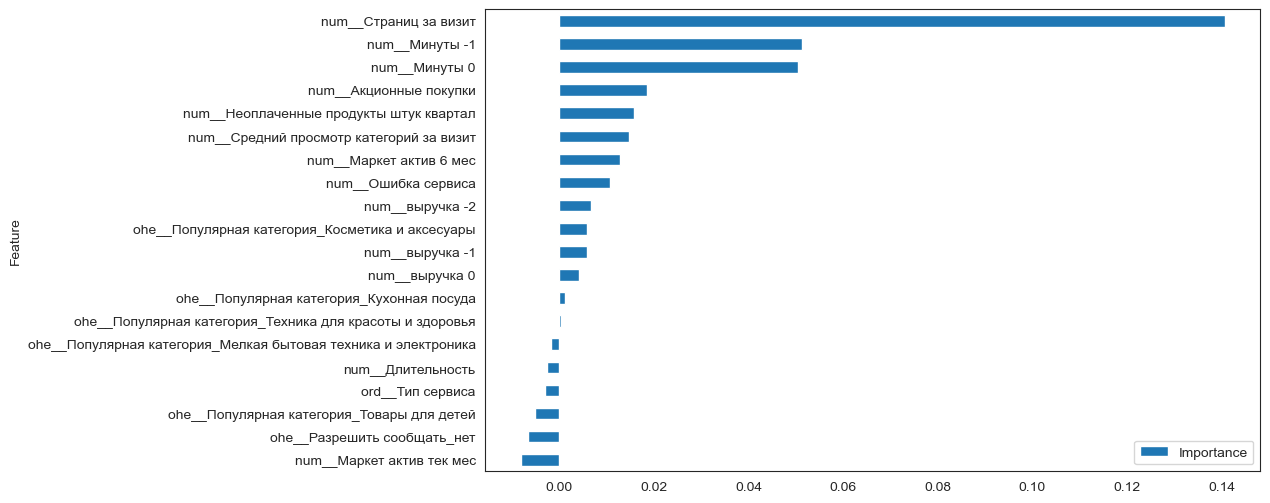

In [925]:
result = permutation_importance(model_1, X_test_1, y_test, scoring=custom_f1)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.show()

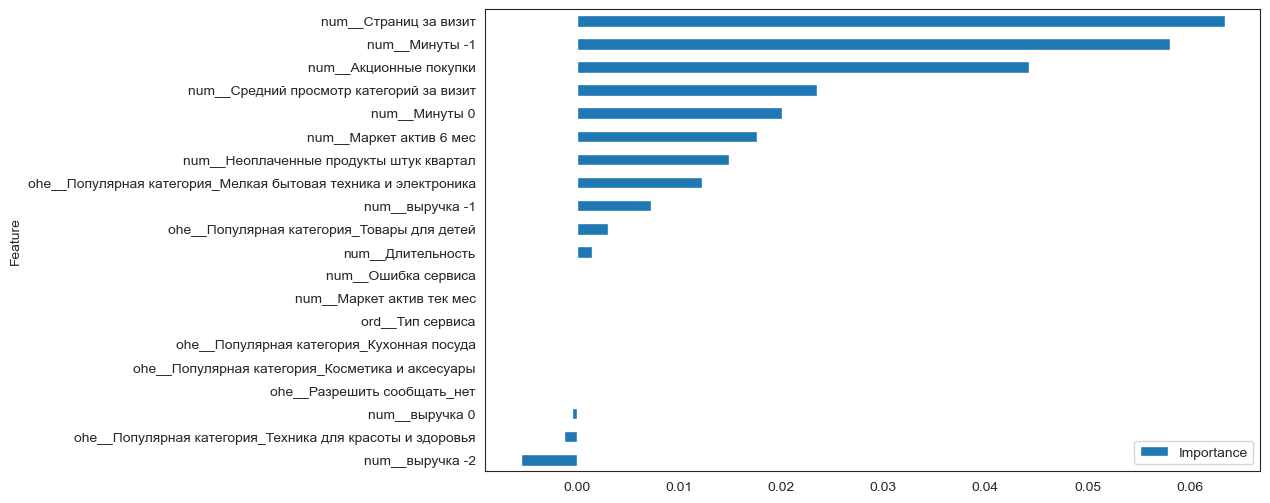

In [926]:
result = permutation_importance(model_2, X_test_2, y_test, scoring=custom_f1)

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.show()

<!-- result = permutation_importance(model_3, X_test_3, y_test, scoring=custom_f1)
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': result['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
sns.set_style('white')
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6)) 
plt.show() -->

Несмотря, на существенную разницу в значимости признаков, наиболее значимые признаки в моделях совпадают. Интересно, что первая модель отдает предпочтение числу страниц за посещение с большим отрывом, в то время, как вторая распределила важность признаков более равномерно и фактически обнулила значительную их часть через регуляризацию. Отметим также высокий вес OHE колонки во второй модели, где указана популятная категория мелкая бытовая техника и электроника. 

В целом, вторая модель выглядит более надежной и простой в применении и интерпретации, выберем её для дальнейшего рассмотрения

### Анализ важности признаков выбранной модели

Оценим важность признаков выбранной модели используя графики SHAP

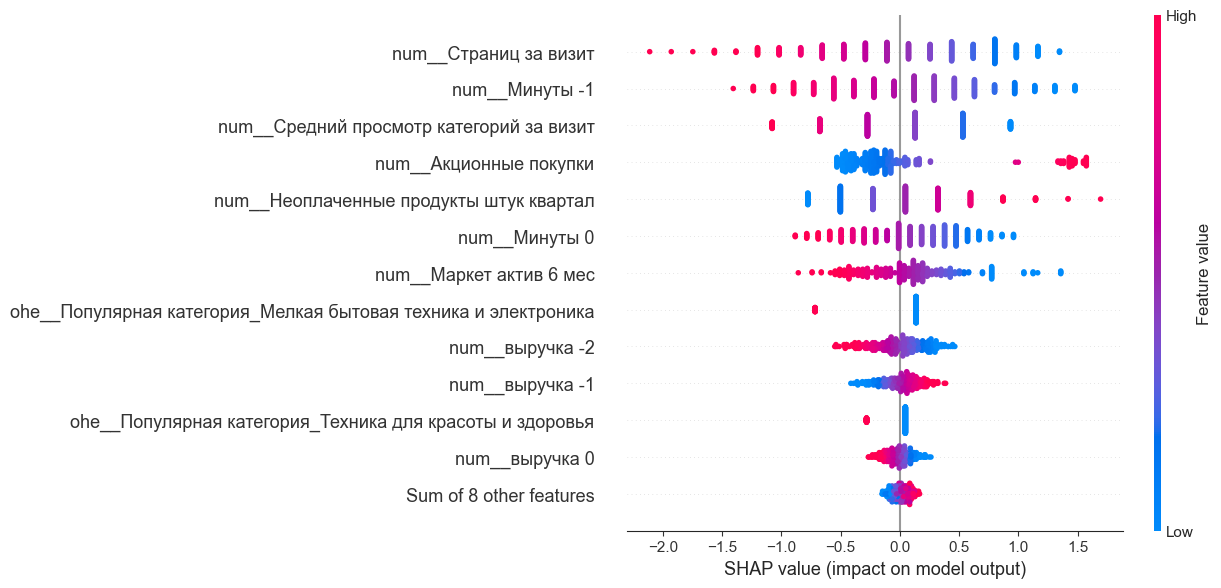

In [932]:
import shap
explainer = shap.LinearExplainer(model_2, X_test_2)
shap_values = explainer(X_test_2)
shap.plots.beeswarm(shap_values,max_display=13) 

Мы видим, что высокое среднее число просмотренных категорий за визит и минут на сайте больше всего снижает вероятность падения покупательской активности. Также на результат существенно влияют метрики, связанные с маркетинговой активностью.

Большое число акционных покупок свидетельствует скорее о предстоящем падении активности. Возможно эти данные отражают поведение группы клиентов, большая доля покупок которых приходилась на акционные товары. Эту группу мы отчетливо видели на гистограммах и диаграммах рассеивания.

Отметим разнонаправленное влияние признаков выручка -2, выручка -1 и выручка 0 с убывающей, по мере приближения, значимостью. Разнонаправленность не выглядит логичной, но похожий паттерн мы видели permutation importance первой модели, возможно стоит дополнительно проанализировать данные выручки -1 и запросить методологию расчета покупательской активности, чтобы понять, снижение на какой именно момент времени фиксируется к какому месяцу. Например снижение может фиксироваться между -1 и 0, тогда высокая выручка -1 может с большей вероятности снизиться до среднего значения

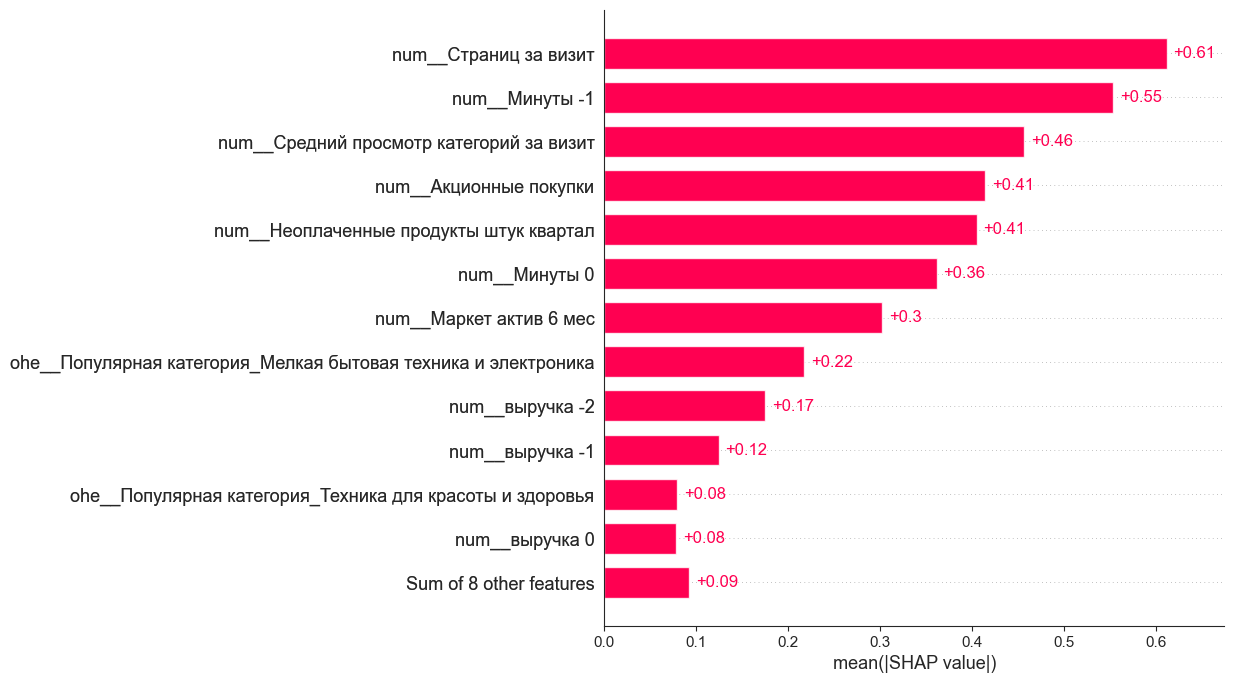

In [934]:
shap.plots.bar(shap_values, max_display=13) 

Интересно, что, кроме количественных признаков, после нормализации, модель оставила две популярные категории покупок. Возможно, при проведении маркетинговых акций, имеет смысл делать больший упор, например, на технику для красоты и здоровья и бытовую электронику. 

### Наблюдения по важности признаков 

Обе модели в тестах permutation importance показали похожий приоритет важности признаков, при этом, выбранная версия логистической регрессии с RobustScaler() показала меньший разброс. Возможно это связано с большим числом автоматически обнуленных регуляризацией признаков, модель вбирает меньше "шума". 

Список признаков приблизительно совпал с нашими ожиданиями по результатам корреляционного анализа, кроме числовых, мы также видим две популярные категории после кодировщика OHE

## Сегментация покупателей

Далее наша задача провести сегментацию покупателей по вероятности снижения покупательской активности и прибыли из оставшегося не добавленного датафрейма

### Добавление сегментов 

Индексы сброшены не были, можем легко объединить колонки

In [942]:
df_2 = preprocessing_2.transform(df)
df_2 = pd.DataFrame(df_2, columns=feature_names)

# добавляем proba 1 и возвращаем id
y_proba = model_2.predict_proba(df_2)[:, 1]
df_2['id'] = df['id']
df_2['Вер. снижения активности'] = y_proba

# объединяем датафреймы и возвращаем активность
df_2 = df_2.merge(df_money, on='id', how='left')
df_2['Покупательская активность'] = df['Покупательская активность']

# добавляем новые колоеки с сегментами 
df_2['Сегмент активности'] = pd.cut(df_2['Вер. снижения активности'],
                              bins=[0, 0.3, 0.7, 1],
                              labels=[0, 1, 2])
df_2['Сегмент прибыли'] = pd.cut(df_2['Прибыль'],
                              bins=[0, 3, 5, 10],
                              labels=[0, 1, 2])

Посмотрим случайную выборку, чтобы удостовериться, что все работает

In [944]:
df_2.sample(5)

,ohe__Разрешить сообщать_нет,ohe__Популярная категория_Косметика и аксесуары,ohe__Популярная категория_Кухонная посуда,ohe__Популярная категория_Мелкая бытовая техника и электроника,ohe__Популярная категория_Техника для красоты и здоровья,ohe__Популярная категория_Товары для детей,ord__Тип сервиса,num__Маркет актив 6 мес,num__Маркет актив тек мес,num__Длительность,...,num__выручка -1,num__выручка -2,num__Минуты 0,num__Минуты -1,id,Вер. снижения активности,Прибыль,Покупательская активность,Сегмент активности,Сегмент прибыли
788,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.230769,0.0,0.242574,...,0.803343,0.859169,0.000000,0.142857,216151,0.374637,6.13,Прежний уровень,1,2
1146,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.769231,0.0,0.551980,...,-0.230641,-0.376900,0.333333,0.000000,216509,0.032821,2.57,Прежний уровень,0,0
1217,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,-0.237624,...,0.428969,0.002026,0.000000,0.857143,216580,0.122646,4.41,Прежний уровень,0,1
292,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.538462,1.0,0.789604,...,-1.711421,-0.091185,-0.500000,0.000000,215644,0.891808,2.86,Снизилась,2,0
207,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.153846,-1.0,0.225248,...,0.915877,0.462006,-0.666667,-0.285714,215559,0.590906,3.58,Снизилась,1,1


###  Характеристики группы

По заданию, нам нужно выбрать один сегмент для дополнительного анализа. Рассмотрим сегмент с большой вероятностью снижения покупательской активности и высокой прибылью.

Для начала, посчитаем сколько клиентов попало в этот сегмент 

In [947]:
len(df_2[(df_2['Сегмент активности']==2)
         &(df_2['Сегмент прибыли']==2)])

51

Посмотрим сколько предсказаний из этого сегмента совпало со снижением активности

In [949]:
round((len(df_2[(df_2['Сегмент активности']==2)
          &(df_2['Сегмент прибыли']==2)
          &(df_2['Покупательская активность']=='Снизилась')])
 /len(df_2[(df_2['Сегмент активности']==2)
         &(df_2['Сегмент прибыли']==2)])),2)

0.92

Результат выглядит реалистично, учитывая, что сегмент активности 2 начинается с proba 0.7

Посмотрим при помощи SHAP, как признаки повлияли на предсказания активности внутри сегмента

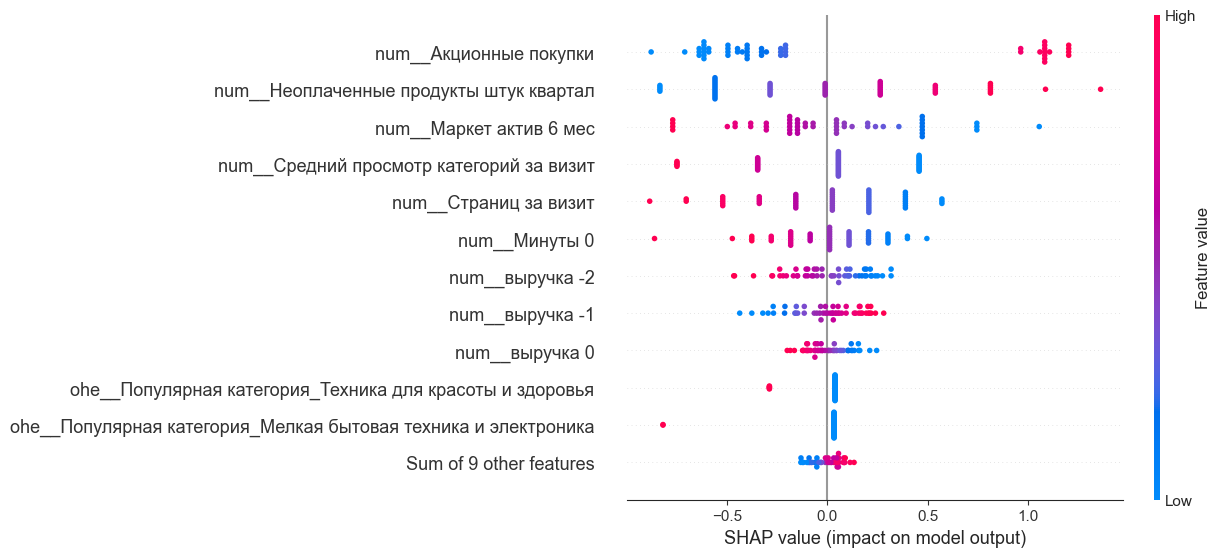

In [952]:
df_shap_3_2_2 = df_2[(df_2['Сегмент активности']==2)
                     &(df_2['Сегмент прибыли']==2)].drop(columns=df_2.columns[-7:-1])
explainer = shap.LinearExplainer(model_2, df_shap_3_2_2)
shap_values = explainer(df_shap_3_2_2) 
shap.plots.beeswarm(shap_values, max_display=12) 

Самым весомым признаком, неожиданно, оказалось число акционных покупок, а на втором месте мы видим число неоплаченных покупок за квартал. Судя по графику, в существенной части случаев, доля акционных покупок настолько велика, что влияние этого признака становится подавляющим при классификации.

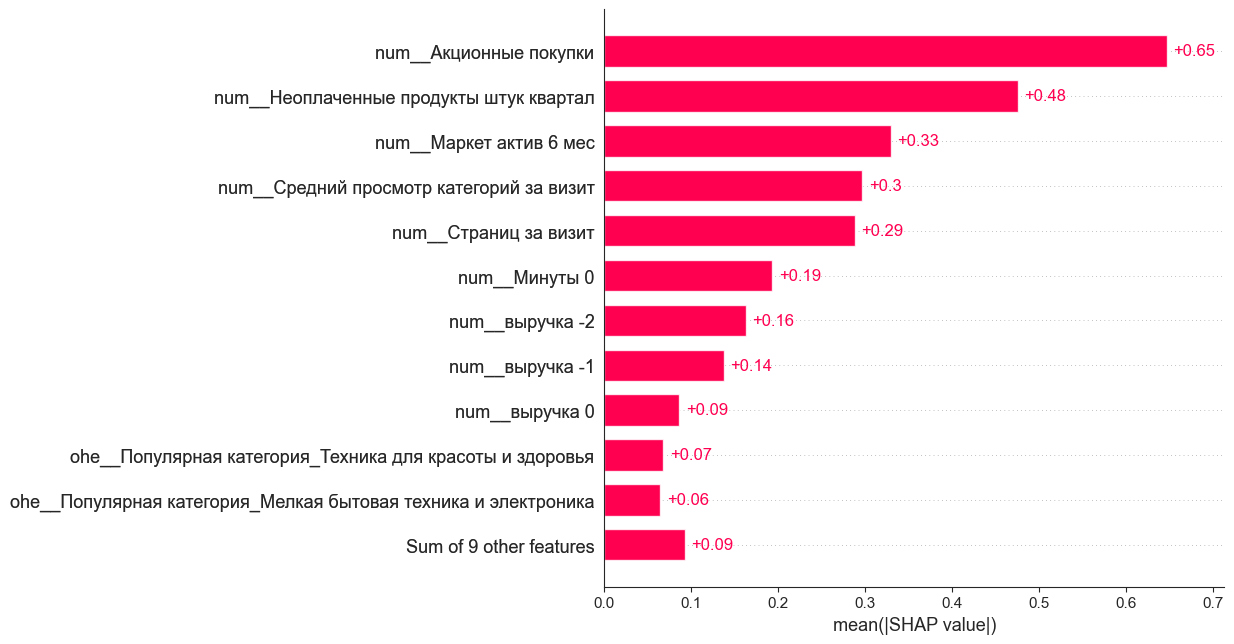

In [954]:
shap.plots.bar(shap_values, max_display=12) 

Мы опять видим две популярные категории, для покупок, которые интерпретируются моделью, как способствующие удержанию активности. Посмотрим, сколько этих наблюдений в категории

In [956]:
df_2[(df_2['Сегмент активности']==2)&(df_2['Сегмент прибыли']==2)][
    'ohe__Популярная категория_Мелкая бытовая техника и электроника'].sum()

2.0

In [957]:
df_2[(df_2['Сегмент активности']==2)&(df_2['Сегмент прибыли']==2)][
    'ohe__Популярная категория_Техника для красоты и здоровья'].sum()

6.0

Суммарно около 15% и довольно существенное влияние признаков на предсказания модели. Эти категории могут быть потенциальными кандидатами для промо акций  

Признаки мы можем логически разделить на четыре категории

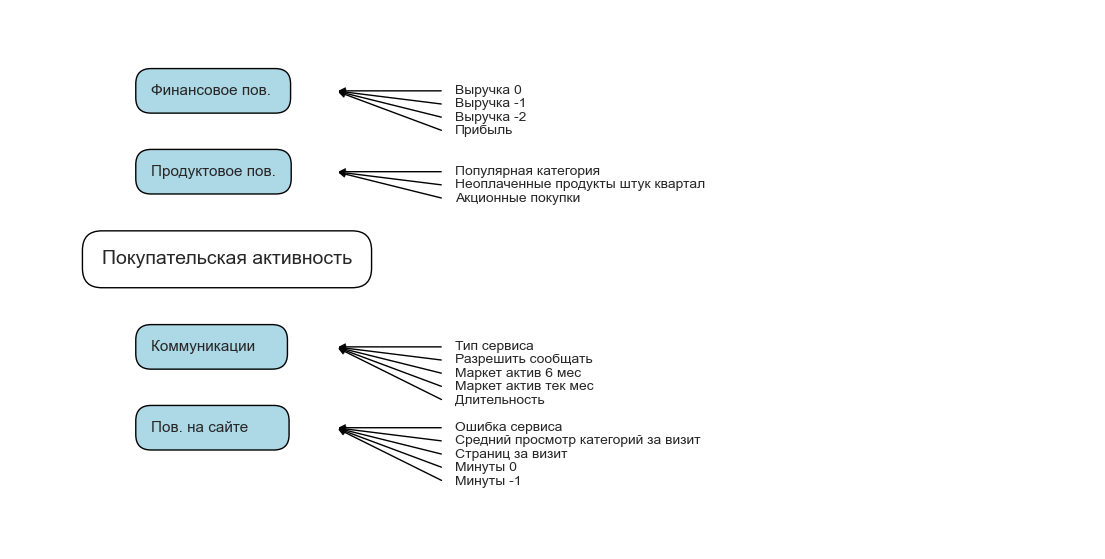

In [960]:
problem = 'Покупательская активность'
feature_groups = {
    'Коммуникации    ': ['Тип сервиса', 'Разрешить сообщать',
           'Маркет актив 6 мес', 'Маркет актив тек мес', 'Длительность'],
    'Продуктовое пов.': ['Популярная категория','Неоплаченные продукты штук квартал',
            'Акционные покупки'],
    'Пов. на сайте      ': ['Ошибка сервиса', 'Средний просмотр категорий за визит',
            'Страниц за визит', 'Минуты 0', 'Минуты -1'],
    'Финансовое пов. ': ['Выручка 0', 'Выручка -1', 'Выручка -2', 'Прибыль']
}

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_xlim(0, 10)
ax.set_ylim(-4, 4)
ax.axis('off')  

for i, (group, sub_categories) in enumerate(feature_groups.items()):
    y = -1 if i % 2 == 0 else 1  
    length = 1 + (i * 0.6)
    ax.text(1.3, y * length, group, ha='left', va='center',
            fontsize=11, bbox=dict(boxstyle="round,pad=1", edgecolor='black', facecolor='lightblue'))

    for j, sub_category in enumerate(sub_categories):
        sub_length = length + (0.2 if y < 0 else -0.2) * j
        ax.annotate('', xy=(3, y * length), xytext=(4, y * sub_length),
                    arrowprops=dict(arrowstyle='->', lw=1, color='black'))
        ax.text(4.1, y * sub_length, sub_category, ha='left', va='center', fontsize=10)

ax.text(2, 0.3, problem, ha='center', va='center',
        fontsize=14, bbox=dict(boxstyle="round,pad=1", edgecolor='black', facecolor='white'))

plt.show()



Не везде внутри групп признаков мы видим сильную взаимосвязь на матрицах корреляций, например, между популярной категорией и акционными покупками или выручкой -2 и выручкой 0 корреляция практически отсутствует. То есть, на первый взгляд, это разделение по логическим группам не всегда отчетливо подтверждено данными 

Применительно к нашей категории пользователей, мы можем обозначить следующие группы из признаков с не обнуленными весам 

Акционные покупки, неоплаченные покупки и популярные категории можно условно объединить, как признаки продуктового поведения. Эта группа признаков имеет самое высокое значение, для категории.

Вторая группа —  число страниц за визит, число просмотренных категорий за визит, минуты на сайте. Условно эту группу можно назвать поведение на сайте.

В третьей группе можно определить один признак, количество маркетинговых коммуникаций за 6 месяцев. Более близкая по времени, но выглядевшая не слишком информативной, по результатам рассмотрения во время исследовательского анализа данных, маркетинговая активность в текущем месяце была удалена регуляризацией Лассо. 

К последней по значимости группе мы можем отнести признаки с выручкой. Интересно, что значимость признака выручка -2 выше, чем выручка -1 или 0, но минуты 0 в список параметров попали, в отличие от минут -1. 

Необычно выглядят данные по количеству дней с даты регистрации. Это не слишком важный для модели признак, но неожиданно, что большее значение ассоциируется с повышенной вероятностью снижения активности. Это может быть связано с тем, что самая популярная категория — товары для детей и покупатели по мере роста ребенка не переключаются на другие категории.   

### Дополнительные наблюдения  

Учитывая результаты значимости по времени сбора данных для признака 'выручка', попробуем оценить другой очевидный сегмент — пользователи с падающей выручкой и падающим количеством минут, проведенных на сайте

In [966]:
df_2[(df_2['num__выручка 0']<df_2['num__выручка -1'])
     & (df_2['num__выручка -1']<df_2['num__выручка -2'])
     & (df_2['num__Минуты 0']<df_2['num__Минуты -1'])].value_counts('Покупательская активность')

Покупательская активность
Прежний уровень    141
Снизилась           19
Name: count, dtype: int64

Доля покупателей со снизившейся активностью, в этой группе ниже, чем в среднем по датафрейму. Мы не знаем методологию расчёта покупательской активности, возможно это сильно запаздывающий индикатор или именно метрика условного интереса. По коэффициентам SHAP мы видим, что ключевое значение имеет количество просмотров категорий, минуты на сайте, число категорий за визит и т.д., но не выручка. 

SHAP показал, что высокая выручка -2 положительно влияет на сохранение покупательской активности, но не показал того же для выручки -1 или 0. Минуты -1 также сильнее влияют на сохранение активности, чем минуты 0, что может свидетельствовать о запаздывании индикатора. Для нас это может быть позитивно, учитывая, что мы прогнозируем наперед, а не пытаемся угадать значение сейчас. Теоретически, при прогнозировании, мы можем смещать недавние показатели по выручке, например, на месяц или два назад. Однако, прежде, чем рассматривать подобные изменения, желательно проанализировать методологию определения признака покупательская активность.

### Предложения 

Если говорить о сегменте с высокой прибылью и высокой вероятностью снижения покупательской активности, при проведении промо акций нужно учитывать, что высокая доля акционных покупок в сегменте является отрицательным фактором продуктового поведения. Частично мы можем это компенсировать добавлением в предложения категорий 'мелкая бытовая техника' и 'техника для красоты и здоровья'. Выручка также является фактором удержания активности, возможно мы можем предоставлять скидку на покупку товара из обозначенных категорий при сумме покупки выше некоторого лимита. Логически, кажется, что это также может сократить число неоплаченных покупок из корзины, если они будут использоваться для достижения минимальной суммы и стимулировать рост времени, проведенного на сайте.

Также, было бы интересно посмотреть на категории товаров, добавленных в корзину без оплаты. Возможно, в дополнение к двум предложенным категориям, можно рассмотреть популярные категории без оплаты.  

## Общий вывод

Наша задача была помочь удержать уровень покупательской активности существующих клиентов с помощью персонализированных предложений, направленных на пользователей с высокой вероятностью её снижения. 

В качестве исходных данных нам было предоставлено четыре таблицы с данными о продуктовом и финансовым поведении, поведении на сайте и маркетинговым коммуникациям. Данные не содержали пропусков, но было необходимо удалить небольшое количество дубликатов, у которых, при этом, оказались разные номера id. В таблицах была информация по выручке за три месяца и время, проведенное на сайте за два месяца.

Качество данных — высокое, исследовательский анализ данных не обнаружил каких-либо очевидно ошибочных значений и распределение между мажорным и минорным классом целевого признака было достаточно равномерным, чтобы при построении модели мы могли использовать обычную стратификацию тестовой выборки.

Поиск модели был произведен при помощи рандомизированного подбора гиперпараметров масштабирования количественных признаков и четырех типов моделей. Учитывая, что в описании задач не был отдан приоритет ошибкам первого или второго типа и распределение по классам целевого признака достаточно равномерно, для оценки мы использовали метрику ROC_AUC. 

В результате мы получили три типа моделей с достаточно похожим результатом при кросс-валидации. Выбрана для дальнейшего использования была логистическая регрессия как показавшая более высокий результат на тестовой выборке и более простая в использовании. Используемая в модели l1 регуляризация с низким C фактически произвела отбор наиболее значимых признаков. 

Был проведен дополнительный анализ в сегменте покупателей с высокой прибылью и высокой вероятностью снижения покупательской активности. В результате для проведения таргетных акций предложено предоставление скидок на товары в категориях 'мелкая бытовая техника' и 'техника для красоты и здоровья' или для популярной категории среди добавленных в корзину, но не оплаченных товаров,  при условии достижения порогового значения по общей сумме покупки.

GitHub repository link 
https://github.com/s0673468/LP1